# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Estimating Galaxy Shape and Flux with CNNs


**Harvard University**<br/>
**CS109b Spring 2020, Final Project F**<br/>
**Group 30**: Ziwei Qiu, Hayden Joy, Zachary Murray, and Daniel Cox


<hr style="height:2pt">

In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### Summary:

**Main Goals:**
* We have built convolutional neural networks (CNN) to reconstruct Sersic model parameters from galaxy images simulated with galsim.
* We have explored different CNN model architecutres, outputing either 1 parameter per model or 5 parameters at once.
* We quantified prediction uncertainties given a certain SNR and compared the models' performances to one another and the theoretical Cramer-Rao bound.

**Stretch Goals:**
* We have constructed a baseline model using traditional fitting methods instead of neural networks to compare to our neural networks.
* We have examined the effects that differences in point spread function between the training and testing data have on the quality of our best model.
* We have examined the effects having galaxies off center in the training and testing data influence model perfromance.

**General conclusion:**
* Our best model estimates the Sersic parameters of simulated galaxies fairly well, often showing inaccuracies close to the Cramer-Rao bound. The Sersic index; however, the model finds most difficult to accurately predict.

## Table of Contents

### Main Goals:
   
* [CNN models predicting one parameter at a time](#CNN-models-predicting-one-parameter-at-a-time)
    * [Regression on label0 - flux](#Regression-on-label0---flux)
    * [Regression on label1 - Sersic index](#Regression-on-label1---Sersic-index)
    * [Regression on label2 - Sersic radius](#Regression-on-label2---Sersic-radius)
    * [Regression on label3 - g1](#Regression-on-label3---g1)
    * [Regression on label4 - g2](#Regression-on-label4---g2)
    
 
* [CNN model predicting five parameters at once](#CNN-model-predicting-five-parameters-at-once)
    * [Model architecture and fitting](#Model-architecture-and-fitting)
    * [Predicting each parameter](#Predicting-each-parameter)
    * [Estimating uncertainties and comparing to the Cramer-Rao bound](#Estimating-uncertainties-and-comparing-to-the-Cramer-Rao-bound)
    * [Saving the uncertainty estimates](#Saving-the-uncertainty-estimates)
    

* [Comparing Models](#Comparing-Models)
    
### Stretch Goals

* [Stretch Goal: Varying PSF](#Stretch-Goal:-Varying-PSF)
    * [Importing data](#Importing-data)
    * [Declaring again our CNN (5 output)](#Declaring-again-our-CNN-(5-output))
    * [Fitting the model to the psf=0.5 training data](#Fitting-the-model-to-the-psf=0.5-training-data)
    * [Making predictions on each set of test data](#Making-predictions-on-each-set-of-test-data)
    * [Plotting predicted vs true value](#Plotting-predicted-vs-true-value)
    * [Our model trained on the original data ](#Our-model-trained-on-the-original-data )
    * [PSF analysis conclusion](#PSF-analysis-conclusion)
    
    
* [Stretch Goal: Off-center Galaxies](#Strech-Goal:-Off-center-Galaxies)
    * [Importing data and making train and test datasets](#Importing-data-and-making-train-and-test-datasets)
    * [Looking at perturbed galaxies](#Looking-at-perturbed-galaxies)
    * [Two training sets](#Two-training-sets)
    * [Fitting the model to all the data](#Fitting-the-model-to-all-the-data)
    * [Comparing Predictions to True values](#Comparing-Predictions-to-True-values)
    
    
* [Stretch Goal: Baseline Models](#Stretch-Goal:-Baseline-Models)
    * [Flux Model : Aperature Photometry](#Flux-Model-:-Aperature-Photometry)
    * [Sersic Radius & Index Model](#Sersic-Radius-&-Index-Model)
    * [g1 and g2 model](#g1-and-g2-model)
    * [Summary: baseline models](#Summary:-baseline-models)
    
    
* [Conclusions](#Conclusions)




### Import libraries

In [0]:
import sys
import math
import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

###  Importing data, making train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [0]:
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

total number of images: 18779


In [0]:
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = np.sort(train_ind)
test_ind = ind[split:]
test_ind = np.sort(test_ind)

# train dataset
image_tr = f['img'][train_ind]
cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

training set done.
test set done.


In [0]:
# Reshape such that the images are ready for training
image_tr = image_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_te.reshape(image_te.shape[0],64,64,1)

image_nonoise_tr = image_nonoise_tr.reshape(image_nonoise_tr.shape[0],64,64,1)
image_nonoise_te = image_nonoise_te.reshape(image_nonoise_te.shape[0],64,64,1)

image_withnoise_tr = image_withnoise_tr.reshape(image_withnoise_tr.shape[0],64,64,1)
image_withnoise_te = image_withnoise_te.reshape(image_withnoise_te.shape[0],64,64,1)

In [0]:
# An example from the training set
fig= plt.figure(figsize=(3,3))
plt.imshow(image_withnoise_tr[1,:,:,0])
plt.colorbar()
plt.show()

In [0]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

## CNN models predicting one parameter at a time
####  Defining common functions for regression and defining a training function

In [0]:
# Three different model architectures
def build_model_shallow(verbose = 1): # The number of filters is relatively small.
    cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(8, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()

def build_model_deep(verbose = 1): # The number of filters is relatively large.
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(16, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.2))

    cnnmodel1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(128, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()
        
def build_model_deep2(verbose=1): # The number of filters is relatively large and in a descending order.
    cnnmodel1.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
    cnnmodel1.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))
    cnnmodel1.add(Dropout(0.1))

    cnnmodel1.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
    cnnmodel1.add(layers.BatchNormalization())
    cnnmodel1.add(layers.MaxPooling2D((2, 2)))

    cnnmodel1.add(layers.Flatten())
    cnnmodel1.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
    cnnmodel1.add(layers.Dense(1, activation='linear'))
    
    if verbose:
        cnnmodel1.summary()

#### Saving the lowest val_loss model and stop when the time is over

In [0]:
def smart_training(cnnmodel, label_ind, weight_filename, 
                   max_time_min = 45, lr_ini = 0.001, lr_decay = 0.5, 
                   val_loss_goal = 0.05, verbose=0):
    
    ''' max_time_min: the longest training time in minutes '''
    
    tic = time.time()
    lr = lr_ini
    opt = SGD(lr=lr, momentum=0.9)
    cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
    cnnmodel_fit = cnnmodel.fit(image_withnoise_tr, label_tr_scaled[:,label_ind], epochs=1,
                                batch_size=64, shuffle=True, verbose=verbose, 
                                validation_data=(image_withnoise_te, label_te_scaled[:,label_ind]))
    cnnmodel.save_weights(weight_filename)
    current_val_loss = cnnmodel_fit.history['val_loss'][-1]
    print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
    
    while True:
        if time.time() - tic > max_time_min*60:
            print('{} min has passed. Time is over!'.format(max_time_min))
            break
        
        cnnmodel_fit = cnnmodel.fit(image_withnoise_tr, label_tr_scaled[:,label_ind], epochs=1,
                                    batch_size=64, shuffle=True, verbose=verbose, 
                                    validation_data=(image_withnoise_te, label_te_scaled[:,label_ind]))
        if cnnmodel_fit.history['val_loss'][-1] < current_val_loss:
            cnnmodel.save_weights(weight_filename)
            current_val_loss = cnnmodel_fit.history['val_loss'][-1]
            print('==> Current val_loss lowest record is: {:0.6f}. Weights saved.'.format(current_val_loss))
            lr = lr*lr_decay
            opt = SGD(lr=lr, momentum=0.9)
            cnnmodel.compile(optimizer=opt,loss='mae',  metrics=['mse','mae'])
        if current_val_loss < val_loss_goal:
            print('Reached the goal! (total training time: {} min)'.format(int((time.time() - tic)/60)))
            break

#### Loading pre-trained weights and evaluate the validation loss

In [0]:
def load_weights(cnnmodel, label_ind, weight_filename):
    #opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    opt = SGD(lr=0.001, momentum=0.9)
    cnnmodel.compile(optimizer=opt, loss='mae', metrics=['mse','mae'])
    cnnmodel.load_weights(weight_filename)
    print("Loaded " + weight_filename + " from disk")
    
    #  Evaluate the model on the validation data:
    val_loss = cnnmodel.evaluate(image_withnoise_te, label_te_scaled[:,label_ind],verbose = 0)
    print('The validation loss MAE is {:0.6f}.'.format(val_loss[0]))

#### Visualizing the prediction versus true values using test data

In [0]:
# Evaluation
def plot_prediction(cnnmodel, label_ind, num_of_pts = 200, X_test = image_withnoise_te):

    indices = np.random.randint(0,X_test.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    single_scaler.fit(np.expand_dims(label_tr[:,label_ind],axis=1))
    
    label_pred_scaled = cnnmodel.predict(X_test[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(4,3))
    plt.scatter(label_te[indices,label_ind],label_pred, 
                c = snr_te[indices], marker = '.', cmap="seismic", s = 20)
    plt.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    plt.xlabel('True Value', fontsize = 13)
    plt.ylabel('Predicted Value', fontsize = 13)
    plt.title(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

def plot_prediction2(cnnmodel, label_ind, num_of_pts = 200, X_test = image_withnoise_te):

    indices = np.random.randint(0,X_test.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    single_scaler.fit(label_tr)

    label_pred_scaled = cnnmodel.predict(X_test[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(4,3))
    plt.scatter(label_te[indices,label_ind],label_pred[:, label_ind], 
                c = snr_te[indices], marker = '.',cmap="seismic", s = 20)
    plt.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    plt.xlabel('True Value', fontsize = 13)
    plt.ylabel('Predicted Value', fontsize = 13)
    plt.title(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

#### Estimating prediction uncertainty. 

Procedure:
- (1) Randomly select a number of test data points. Take those no_noise images.
- (2) For each of the no_noise test image, generate many noisy images given a SNR. Feed these noisy images into the trained model. Take the mean and standard deviation of the prediction, and latter is the prediction uncertainty at that point.
- (3) Repeat Step (2) for all the no_noise test images. Calcalate the prediction mean and uncertainties.
- (4) Plot the prediction with errorbars.

In [0]:
def make_noisy_galaxy(galaxy_no_noise, snr, size):
    '''input: galaxy_no_noise is of shape (64,64,1)
       output is a bunch of noisy galaxies with pre-defined SNR, of shape (size, 64,64,1)    
    '''
    galaxy_reshaped = galaxy_no_noise[:,:,0]
    galaxy_with_noise = np.zeros((size,64,64))
    for i in range(size): 
        noise = np.sqrt((galaxy_reshaped**2).sum()) / snr
        noisemap = np.random.normal(0, noise, 64*64)
        noisemap=noisemap.reshape((64,64))
        galaxy_with_noise[i]= galaxy_reshaped+noisemap # final noised image 
    galaxy_with_noise = galaxy_with_noise.reshape(galaxy_with_noise.shape[0],64,64,1)
    # galaxy_with_noise is of shape (size, 64,64,1), ready to be fed into the model 
    return galaxy_with_noise

def get_uncertainty(cnnmodel, label_ind, galaxy_no_noise, snr, size):
    '''Outputs the prediction uncertainty given SNR by bootstrapping noise for many times
    For the model with 1 output'''
    galaxy_with_noise = make_noisy_galaxy(galaxy_no_noise, snr, size)
    single_scaler = StandardScaler()
    single_scaler.fit(np.expand_dims(label_tr[:,label_ind],axis=1))
    label_pred_scaled = cnnmodel.predict(galaxy_with_noise)
    label_pred = single_scaler.inverse_transform(label_pred_scaled)
    
    mean = label_pred.mean()
    sigma = label_pred.std()
    
    return mean, sigma, label_pred

def plot_uncertainty(cnnmodel, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100):
    '''For the model with 1 output'''
    np.random.seed(200)
    indices = np.random.randint(0,image_withnoise_te.shape[0],num_of_pts)
    true_values = label_te[indices,label_ind]
    mean = np.zeros([num_of_pts,2])
    sigma = np.zeros([num_of_pts,2])
    label_pred = np.zeros([num_of_pts, sampling_size])
    x = np.linspace(label_te[:,label_ind].min(),label_te[:,label_ind].max(),20)
    fig,ax = plt.subplots(2,2,figsize=(6,5), sharex = True)
    
    CRB_snr30 = [[1,0.11], [3, 1.56],[0.3, 0.056], [-0.069, 0.11], [0.15, 0.11]]
    CRB_snr60 = [[1,0.056], [3, 0.78],[0.3, 0.028], [-0.069, 0.054], [0.15, 0.054]]
    
    for j in range(2):
        i = 0 
        for idx in indices:
            mean[i,j], sigma[i,j], label_pred_temp = get_uncertainty(cnnmodel, label_ind, image_nonoise_te[idx], snr[j], size=sampling_size)
            label_pred[i] = label_pred_temp[:,0]
            i+=1
        
        ax[0][j].set_title(label_names_list[label_ind]+'\nSNR = {}'.format(snr[j]))
        ax[0][j].errorbar(true_values, mean[:,j], yerr=sigma[:,j], fmt='.', label = 'CNN model')
        ax[0][j].legend()
        ax[0][j].plot(x,x,color = 'tab:orange')
        ax[1][j].scatter(true_values, sigma[:,j], s = 20, label = 'Uncertainty')
        if snr[j] == 30:
            ax[1][j].scatter(CRB_snr30[label_ind][0], CRB_snr30[label_ind][1], s = 20, label = 'CRB')
        elif snr[j] == 60:
            ax[1][j].scatter(CRB_snr60[label_ind][0], CRB_snr60[label_ind][1], s = 20, label = 'CRB')
        ax[1][j].set_xlabel('True Value', fontsize = 13)
        ax[1][j].legend()
    
    ax[0][0].set_ylabel('Predicted Value', fontsize = 13)
    ax[1][0].set_ylabel('Uncertainty',fontsize = 13)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 11})
    plt.show()
    
    return true_values, mean, sigma

def get_uncertainty2(cnnmodel, galaxy_no_noise, snr, size):
    '''For the model with 5 outputs'''
    galaxy_with_noise = make_noisy_galaxy(galaxy_no_noise, snr, size)
    single_scaler = StandardScaler()
    single_scaler.fit(label_tr)
    label_pred_scaled = cnnmodel.predict(galaxy_with_noise)
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    mean = label_pred.mean(axis = 0)
    sigma = label_pred.std(axis = 0)
    
    return mean, sigma, label_pred

def plot_uncertainty2(cnnmodel, snr=[30,60], num_of_pts=50, sampling_size = 100):
    '''For the model with 5 outputs'''
    np.random.seed(200)
    indices = np.random.randint(0,image_withnoise_te.shape[0],num_of_pts)
    true_values = label_te[indices]
    mean = np.zeros([num_of_pts, 5, 2])
    sigma = np.zeros([num_of_pts, 5, 2])
    label_pred = np.zeros([num_of_pts, sampling_size, 5, 2])
       
    CRB_snr30 = [[1,0.11], [3, 1.56],[0.3, 0.056], [-0.069, 0.11], [0.15, 0.11]]
    CRB_snr60 = [[1,0.056], [3, 0.78],[0.3, 0.028], [-0.069, 0.054], [0.15, 0.054]]
    
    for j in range(2):
        i = 0
        for idx in indices:
            mean[i,:,j], sigma[i,:,j], label_pred_temp = get_uncertainty2(cnnmodel, image_nonoise_te[idx], 
                                                                  snr[j], size=sampling_size)
            label_pred[i,:,:,j] = label_pred_temp
            i+=1
    
    for label_ind in range(5):
        x = np.linspace(label_te[:,label_ind].min(),label_te[:,label_ind].max(),20)
        fig,ax = plt.subplots(2,2,figsize=(6,5), sharex = True)
        for j in range(2):
            ax[0][j].set_title(label_names_list[label_ind]+'\nSNR = {}'.format(snr[j]))
            ax[0][j].errorbar(true_values[:,label_ind], mean[:,label_ind,j], 
                              yerr=sigma[:,label_ind,j], fmt='.', label = 'CNN model')
            ax[0][j].legend()
            ax[0][j].plot(x,x,color = 'tab:orange')
            ax[1][j].scatter(true_values[:,label_ind], sigma[:,label_ind,j], s = 20, label = 'Uncertainty')
            if snr[j] == 30:
                ax[1][j].scatter(CRB_snr30[label_ind][0], CRB_snr30[label_ind][1], s = 20, label = 'CRB')
            elif snr[j] == 60:
                ax[1][j].scatter(CRB_snr60[label_ind][0], CRB_snr60[label_ind][1], s = 20, label = 'CRB')
            ax[1][j].set_xlabel('True Value', fontsize = 13)
            ax[1][j].legend()

        ax[0][0].set_ylabel('Predicted Value', fontsize = 13)
        ax[1][0].set_ylabel('Uncertainty',fontsize = 13)
        plt.tight_layout()
        plt.rcParams.update({'font.size': 11})
        plt.show()
        
    return true_values, mean, sigma

#### Creating numpy arrays to save model prediction uncertainties

In [0]:
num_of_pts = 50
true_values_cnn1 = np.zeros([num_of_pts, 5])
mean_cnn1 = np.zeros([num_of_pts, 5,2])
err_cnn1 = np.zeros([num_of_pts, 5,2])

true_values_cnn0 = np.zeros([num_of_pts, 5])
mean_cnn0 = np.zeros([num_of_pts, 5,2])
err_cnn0 = np.zeros([num_of_pts, 5,2])

###  Regression on label0 - flux

##### Architecture 1: Deep CNN layers:

In [0]:
label_ind = 0
cnnmodel1 = models.Sequential()
build_model_deep()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        272       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        4112      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        1

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_flux_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.651924. Weights saved.
==> Current val_loss lowest record is: 0.158461. Weights saved.
==> Current val_loss lowest record is: 0.129894. Weights saved.
==> Current val_loss lowest record is: 0.125682. Weights saved.
==> Current val_loss lowest record is: 0.125087. Weights saved.
120 min has passed. Time is over!


In [0]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_flux_imprvd.h5')

Loaded cnnmodel_flux_imprvd.h5 from disk
The validation loss MAE is 0.125087.


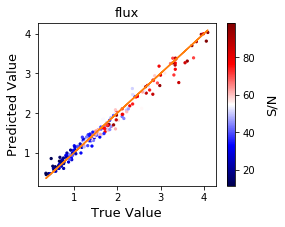

In [0]:
plot_prediction(cnnmodel1, label_ind)

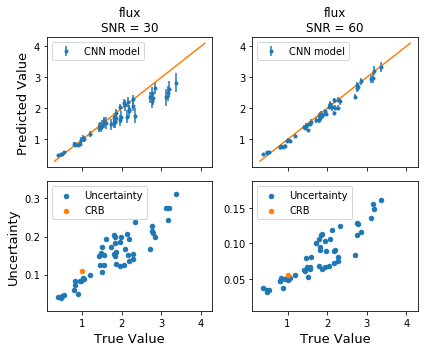

In [0]:
true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind], err_cnn1[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [0]:
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [0]:
label_ind = 0
weights_filename = 'cnnmodel_flux_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 1.056936. Weights saved.
==> Current val_loss lowest record is: 0.263323. Weights saved.
==> Current val_loss lowest record is: 0.144727. Weights saved.
==> Current val_loss lowest record is: 0.134845. Weights saved.
==> Current val_loss lowest record is: 0.129009. Weights saved.
120 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_flux_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_flux_v0.h5 from disk
The validation loss MAE is 0.129009.


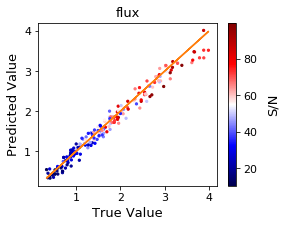

In [0]:
plot_prediction(cnnmodel1, label_ind)

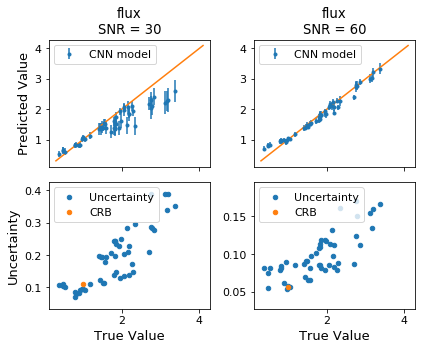

In [0]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100);

##### Architecture 3: Deep CNN layers, number of filters descending:

In [0]:
label_ind = 0
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_flux_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 90, verbose = 0)

==> Current val_loss lowest record is: 0.662918. Weights saved.
==> Current val_loss lowest record is: 0.115552. Weights saved.
==> Current val_loss lowest record is: 0.107425. Weights saved.
90 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_flux_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_flux_imprvd2.h5 from disk
The validation loss MAE is 0.107425.


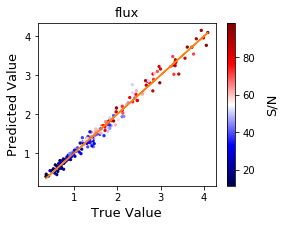

In [0]:
plot_prediction(cnnmodel1, label_ind)

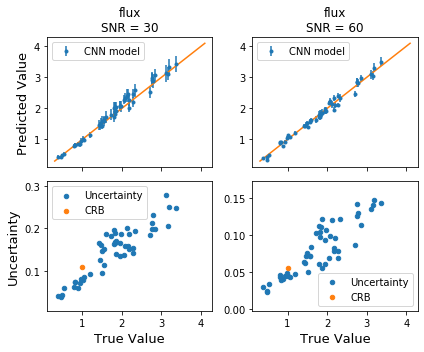

In [0]:
true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind], err_cnn0[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### **Comments:** 
There is no obvious difference between different architectures. The number of filters do not matter much in predicting flux. The prediction uncertainties show good agreement with the Cramer-Rao bound.

### Regression on label1 - Sersic index

##### Architecture 1: Deep CNN layers:

In [0]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.869347. Weights saved.
==> Current val_loss lowest record is: 0.851990. Weights saved.
==> Current val_loss lowest record is: 0.835536. Weights saved.
==> Current val_loss lowest record is: 0.822561. Weights saved.
==> Current val_loss lowest record is: 0.814042. Weights saved.
==> Current val_loss lowest record is: 0.810861. Weights saved.
==> Current val_loss lowest record is: 0.805875. Weights saved.
==> Current val_loss lowest record is: 0.804253. Weights saved.
==> Current val_loss lowest record is: 0.804099. Weights saved.
==> Current val_loss lowest record is: 0.803768. Weights saved.
==> Current val_loss lowest record is: 0.803374. Weights saved.
==> Current val_loss lowest record is: 0.803295. Weights saved.
==> Current val_loss lowest record is: 0.803172. Weights saved.
==> Current val_loss lowest record is: 0.803119. Weights saved.
==> Current val_loss lowest record is: 0.803078. Weights saved.
==> Current val_loss lowest record is: 0

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5', max_time_min = 20, verbose = 0)

==> Current val_loss lowest record is: 0.531.
==> Current val_loss lowest record is: 0.530.
==> Current val_loss lowest record is: 0.524.
==> Current val_loss lowest record is: 0.520.
==> Current val_loss lowest record is: 0.517.
20 min has passed. Time is over!


In [0]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_index_imprvd.h5')

Loaded cnnmodel_index_imprvd.h5 from disk
The validation loss MAE is 0.803027.


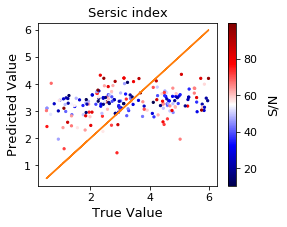

In [0]:
plot_prediction(cnnmodel1, label_ind)

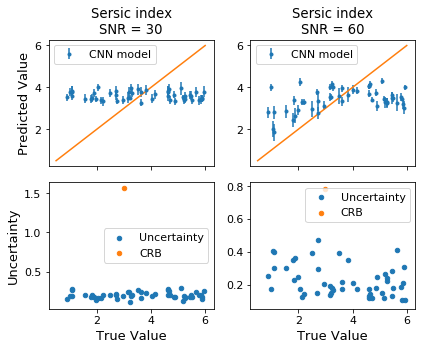

In [0]:
true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind], err_cnn1[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [0]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_index_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.876531. Weights saved.
==> Current val_loss lowest record is: 0.854893. Weights saved.
==> Current val_loss lowest record is: 0.834039. Weights saved.
==> Current val_loss lowest record is: 0.820071. Weights saved.
==> Current val_loss lowest record is: 0.808554. Weights saved.
==> Current val_loss lowest record is: 0.805676. Weights saved.
==> Current val_loss lowest record is: 0.802543. Weights saved.
==> Current val_loss lowest record is: 0.801512. Weights saved.
==> Current val_loss lowest record is: 0.800962. Weights saved.
==> Current val_loss lowest record is: 0.800794. Weights saved.
==> Current val_loss lowest record is: 0.800683. Weights saved.
==> Current val_loss lowest record is: 0.800590. Weights saved.
==> Current val_loss lowest record is: 0.800555. Weights saved.
==> Current val_loss lowest record is: 0.800550. Weights saved.
==> Current val_loss lowest record is: 0.800425. Weights saved.
==> Current val_loss lowest record is: 0

In [0]:
weights_filename = 'cnnmodel_index_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_index_v0.h5 from disk
The validation loss MAE is 0.800240.


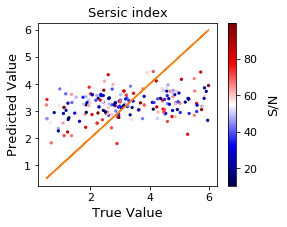

In [0]:
plot_prediction(cnnmodel1, label_ind)

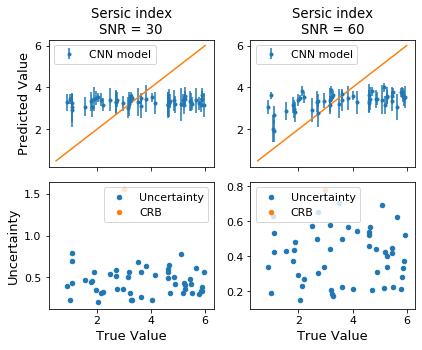

In [0]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100);

##### Architecture 3: Deep CNN layers (channel number descending)

In [0]:
label_ind = 1
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.873166. Weights saved.
==> Current val_loss lowest record is: 0.866865. Weights saved.
==> Current val_loss lowest record is: 0.806643. Weights saved.
==> Current val_loss lowest record is: 0.795880. Weights saved.
==> Current val_loss lowest record is: 0.771939. Weights saved.
==> Current val_loss lowest record is: 0.747715. Weights saved.
==> Current val_loss lowest record is: 0.747371. Weights saved.
==> Current val_loss lowest record is: 0.744005. Weights saved.
==> Current val_loss lowest record is: 0.743563. Weights saved.
120 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 240, verbose = 0)

==> Current val_loss lowest record is: 0.696807. Weights saved.
==> Current val_loss lowest record is: 0.683657. Weights saved.
==> Current val_loss lowest record is: 0.655153. Weights saved.
==> Current val_loss lowest record is: 0.650073. Weights saved.
==> Current val_loss lowest record is: 0.641599. Weights saved.
==> Current val_loss lowest record is: 0.637499. Weights saved.
==> Current val_loss lowest record is: 0.636515. Weights saved.
==> Current val_loss lowest record is: 0.636415. Weights saved.
240 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_index_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_index_imprvd2.h5 from disk
The validation loss MAE is 0.636415.


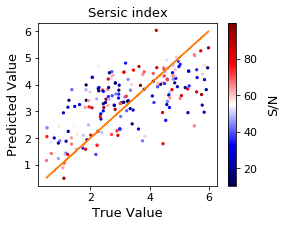

In [0]:
plot_prediction(cnnmodel1, label_ind)

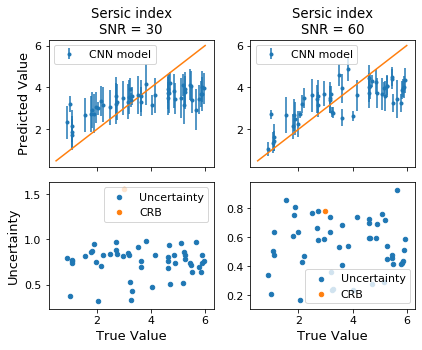

In [0]:
true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind], err_cnn0[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### **Comments:** 

The last CNN architecture with descending number of filters exhibits a much better performance than the first two models with ascending number of filters, regardless of number of filters in each layer. In the first two architectures, the model tends to predict a constant regardless of the input, resulting in a fake prediction uncertainty which is even lower than the Cramer-Rao bound. In the last architecture, the prediction is better at lower Sersic index, but becomes worse at index > 4. 

### Regression on label2 - Sersic radius

##### Architecture 1: Deep CNN layers:

In [0]:
label_ind = 2
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_radius_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.606371. Weights saved.
==> Current val_loss lowest record is: 0.602255. Weights saved.
==> Current val_loss lowest record is: 0.595163. Weights saved.
==> Current val_loss lowest record is: 0.590923. Weights saved.
==> Current val_loss lowest record is: 0.588613. Weights saved.
==> Current val_loss lowest record is: 0.586930. Weights saved.
==> Current val_loss lowest record is: 0.585905. Weights saved.
120 min has passed. Time is over!


In [0]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_radius_imprvd.h5')

Loaded cnnmodel_radius_imprvd.h5 from disk
The validation loss MAE is 0.585905.


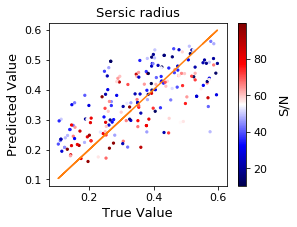

In [0]:
plot_prediction(cnnmodel1, label_ind)

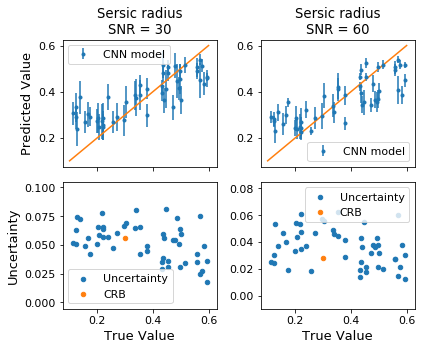

In [0]:
true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind], err_cnn1[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [0]:
label_ind = 2
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_radius_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.715939. Weights saved.
==> Current val_loss lowest record is: 0.682808. Weights saved.
==> Current val_loss lowest record is: 0.667680. Weights saved.
==> Current val_loss lowest record is: 0.644195. Weights saved.
==> Current val_loss lowest record is: 0.635084. Weights saved.
==> Current val_loss lowest record is: 0.628747. Weights saved.
==> Current val_loss lowest record is: 0.624590. Weights saved.
==> Current val_loss lowest record is: 0.624565. Weights saved.
120 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_radius_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_radius_v0.h5 from disk
The validation loss MAE is 0.624565.


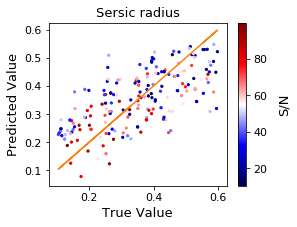

In [0]:
plot_prediction(cnnmodel1, label_ind)

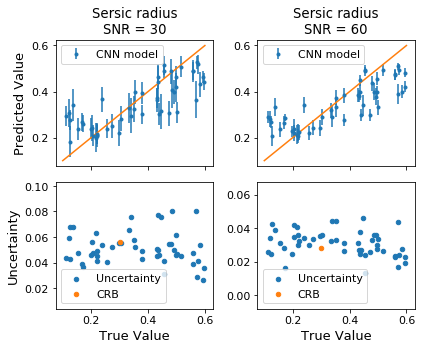

In [0]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100);

##### Architecture 3: Deep CNN layers, number of filters descending:

In [0]:
label_ind = 2
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_radius_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 90, verbose = 0)

==> Current val_loss lowest record is: 0.723325. Weights saved.
==> Current val_loss lowest record is: 0.687040. Weights saved.
==> Current val_loss lowest record is: 0.650924. Weights saved.
==> Current val_loss lowest record is: 0.635492. Weights saved.
==> Current val_loss lowest record is: 0.632800. Weights saved.
==> Current val_loss lowest record is: 0.630081. Weights saved.
==> Current val_loss lowest record is: 0.629749. Weights saved.
==> Current val_loss lowest record is: 0.628447. Weights saved.
==> Current val_loss lowest record is: 0.628161. Weights saved.
90 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_radius_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_radius_imprvd2.h5 from disk
The validation loss MAE is 0.628161.


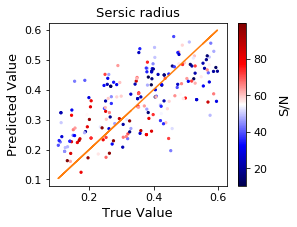

In [0]:
plot_prediction(cnnmodel1, label_ind)

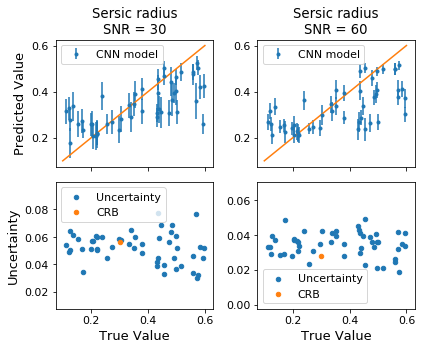

In [0]:
true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind], err_cnn0[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### **Comments:** 
There is no obvious difference between different architectures. The number of filters do not matter much in predicting the Sersic radius. The prediction uncertainties show good agreement with the Cramer-Rao bound.

### Regression on label3 - g1

##### Architecture 1: Deep CNN layers:

In [0]:
label_ind = 3
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_g1_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.571557. Weights saved.
==> Current val_loss lowest record is: 0.524762. Weights saved.
==> Current val_loss lowest record is: 0.385629. Weights saved.
==> Current val_loss lowest record is: 0.364834. Weights saved.
==> Current val_loss lowest record is: 0.356564. Weights saved.
==> Current val_loss lowest record is: 0.356035. Weights saved.
==> Current val_loss lowest record is: 0.354792. Weights saved.
==> Current val_loss lowest record is: 0.353697. Weights saved.
120 min has passed. Time is over!


In [0]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_g1_imprvd.h5')

Loaded cnnmodel_g1_imprvd.h5 from disk
The validation loss MAE is 0.353697.


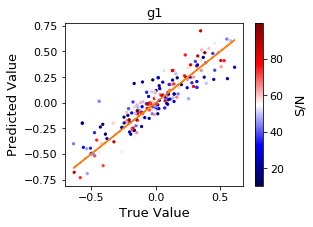

In [0]:
plot_prediction(cnnmodel1, label_ind)

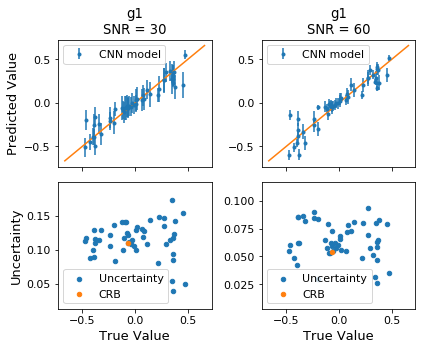

In [0]:
true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind], err_cnn1[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [0]:
label_ind = 3
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_g1_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.761530. Weights saved.
==> Current val_loss lowest record is: 0.616597. Weights saved.
==> Current val_loss lowest record is: 0.495579. Weights saved.
==> Current val_loss lowest record is: 0.384016. Weights saved.
==> Current val_loss lowest record is: 0.381391. Weights saved.
==> Current val_loss lowest record is: 0.376676. Weights saved.
==> Current val_loss lowest record is: 0.373073. Weights saved.
==> Current val_loss lowest record is: 0.371476. Weights saved.
==> Current val_loss lowest record is: 0.371211. Weights saved.
==> Current val_loss lowest record is: 0.371114. Weights saved.
==> Current val_loss lowest record is: 0.370799. Weights saved.
==> Current val_loss lowest record is: 0.370729. Weights saved.
==> Current val_loss lowest record is: 0.370654. Weights saved.
==> Current val_loss lowest record is: 0.370570. Weights saved.
120 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_g1_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g1_v0.h5 from disk
The validation loss MAE is 0.370570.


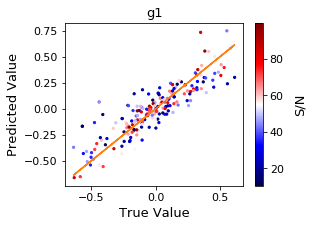

In [0]:
plot_prediction(cnnmodel1, label_ind)

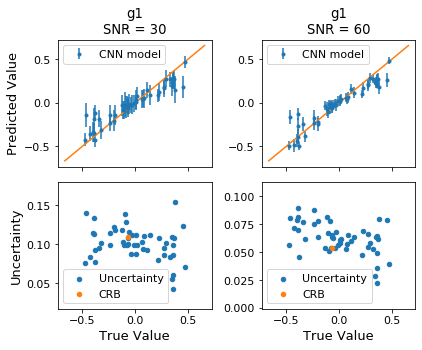

In [0]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100);

##### Architecture 3: Deep CNN layers, number of filters descending:

In [0]:
label_ind = 3
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_g1_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 90, verbose = 0)

==> Current val_loss lowest record is: 0.434689. Weights saved.
==> Current val_loss lowest record is: 0.372945. Weights saved.
==> Current val_loss lowest record is: 0.338851. Weights saved.
==> Current val_loss lowest record is: 0.333995. Weights saved.
==> Current val_loss lowest record is: 0.330451. Weights saved.
==> Current val_loss lowest record is: 0.329337. Weights saved.
90 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_g1_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g1_imprvd2.h5 from disk
The validation loss MAE is 0.329337.


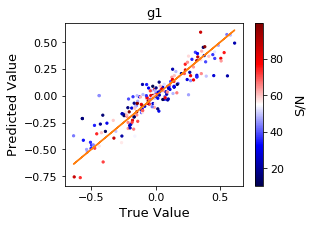

In [0]:
plot_prediction(cnnmodel1, label_ind)

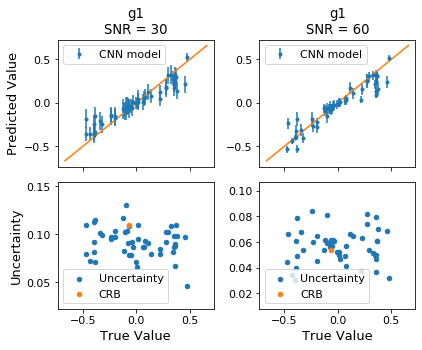

In [0]:
true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind], err_cnn0[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### **Comments:** 
There is no obvious difference between different architectures. The number of filters do not matter much in predicting g1. The prediction uncertainties show good agreement with the Cramer-Rao bound.

### Regression on label4 - g2

##### Architecture 1: Deep CNN layers:

In [0]:
label_ind = 4
cnnmodel1 = models.Sequential()
build_model_deep(verbose = 0)

In [0]:
smart_training(cnnmodel1, label_ind, 'cnnmodel_g2_imprvd.h5', max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.537747. Weights saved.
==> Current val_loss lowest record is: 0.407268. Weights saved.
==> Current val_loss lowest record is: 0.374907. Weights saved.
==> Current val_loss lowest record is: 0.366383. Weights saved.
==> Current val_loss lowest record is: 0.358592. Weights saved.
==> Current val_loss lowest record is: 0.353145. Weights saved.
==> Current val_loss lowest record is: 0.352322. Weights saved.
==> Current val_loss lowest record is: 0.350721. Weights saved.
==> Current val_loss lowest record is: 0.350544. Weights saved.
120 min has passed. Time is over!


In [0]:
load_weights(cnnmodel1, label_ind, 'cnnmodel_g2_imprvd.h5')

Loaded cnnmodel_g2_imprvd.h5 from disk
The validation loss MAE is 0.350544.


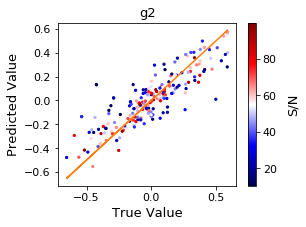

In [0]:
plot_prediction(cnnmodel1, label_ind)

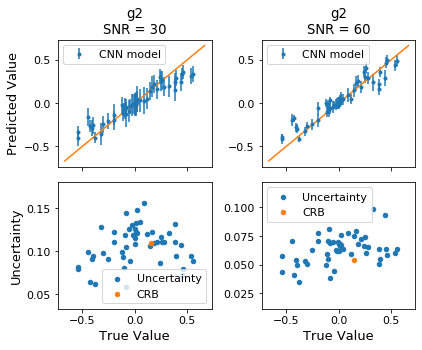

In [0]:
true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind], err_cnn1[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### Architecture 2: Shallower CNN layers:

In [0]:
cnnmodel1 = models.Sequential()
build_model_shallow(verbose = 0)

In [0]:
label_ind = 4
weights_filename = 'cnnmodel_g2_v0.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 120, verbose = 0)

==> Current val_loss lowest record is: 0.767866. Weights saved.
==> Current val_loss lowest record is: 0.533065. Weights saved.
==> Current val_loss lowest record is: 0.471258. Weights saved.
==> Current val_loss lowest record is: 0.441658. Weights saved.
==> Current val_loss lowest record is: 0.437752. Weights saved.
==> Current val_loss lowest record is: 0.435072. Weights saved.
==> Current val_loss lowest record is: 0.430595. Weights saved.
==> Current val_loss lowest record is: 0.425878. Weights saved.
==> Current val_loss lowest record is: 0.423592. Weights saved.
==> Current val_loss lowest record is: 0.423271. Weights saved.
==> Current val_loss lowest record is: 0.422234. Weights saved.
120 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_g2_v0.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g2_v0.h5 from disk
The validation loss MAE is 0.422234.


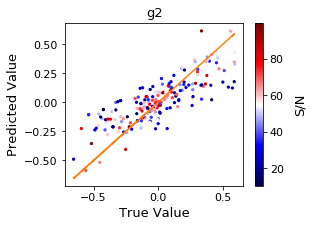

In [0]:
plot_prediction(cnnmodel1, label_ind)

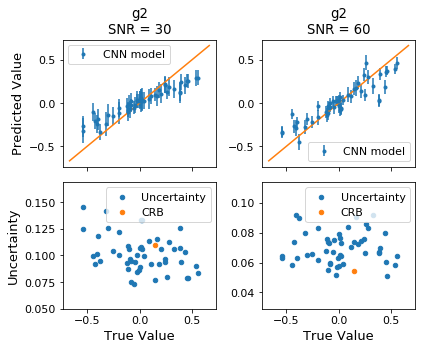

In [0]:
plot_uncertainty(cnnmodel1, label_ind, snr=[30,60], num_of_pts=50, sampling_size = 100);

##### Architecture 3: Deep CNN layers, number of filters descending:

In [0]:
label_ind = 4
cnnmodel1 = models.Sequential()
build_model_deep2(verbose = 0)

In [0]:
weights_filename = 'cnnmodel_g2_imprvd2.h5'
smart_training(cnnmodel1, label_ind, weights_filename, max_time_min = 90, verbose = 0)

==> Current val_loss lowest record is: 0.492128. Weights saved.
==> Current val_loss lowest record is: 0.395999. Weights saved.
==> Current val_loss lowest record is: 0.354568. Weights saved.
==> Current val_loss lowest record is: 0.350253. Weights saved.
==> Current val_loss lowest record is: 0.348833. Weights saved.
==> Current val_loss lowest record is: 0.343744. Weights saved.
==> Current val_loss lowest record is: 0.343409. Weights saved.
==> Current val_loss lowest record is: 0.343161. Weights saved.
==> Current val_loss lowest record is: 0.342769. Weights saved.
90 min has passed. Time is over!


In [0]:
weights_filename = 'cnnmodel_g2_imprvd2.h5'
load_weights(cnnmodel1, label_ind, weights_filename)

Loaded cnnmodel_g2_imprvd2.h5 from disk
The validation loss MAE is 0.342769.


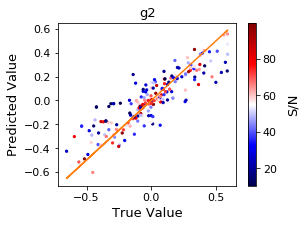

In [0]:
plot_prediction(cnnmodel1, label_ind)

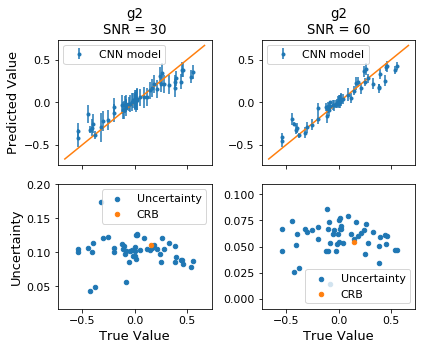

In [0]:
true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind], err_cnn0[:,label_ind] = plot_uncertainty(cnnmodel1, 
                                                                                     label_ind, 
                                                                                     snr=[30,60], 
                                                                                     num_of_pts=num_of_pts,
                                                                                     sampling_size = 100)

##### **Comments:** 
There is no obvious difference between the two architectures. The number of filters do not matter much in predicting g2. The prediction uncertainties show good agreement with the Cramer-Rao bound. 

Both g1 and g2 determine the ellipticity and phi is orientation, so the predictions on these two parameters have similarly good performance.

#### Save the uncertainty estimate results

In [0]:
np.save('model_uncertainty/true_values_cnn0.npy', true_values_cnn0)
np.save('model_uncertainty/mean_cnn0.npy', mean_cnn0)
np.save('model_uncertainty/err_cnn0.npy', err_cnn0)

np.save('model_uncertainty/true_values_cnn1.npy', true_values_cnn1)
np.save('model_uncertainty/mean_cnn1.npy', mean_cnn1)
np.save('model_uncertainty/err_cnn1.npy', err_cnn1)

## CNN model predicting five parameters at once

### Model architecture and fitting
This CNN model has a descending number of filters and outputs 5 parameters at once.

In [0]:
cnnmodel = models.Sequential()
#cnnmodel.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(5, activation='linear'))
cnnmodel.summary()

In [0]:
cnnmodel = models.load_model('cnnmodel2.h5')

In [0]:
cnnmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)       

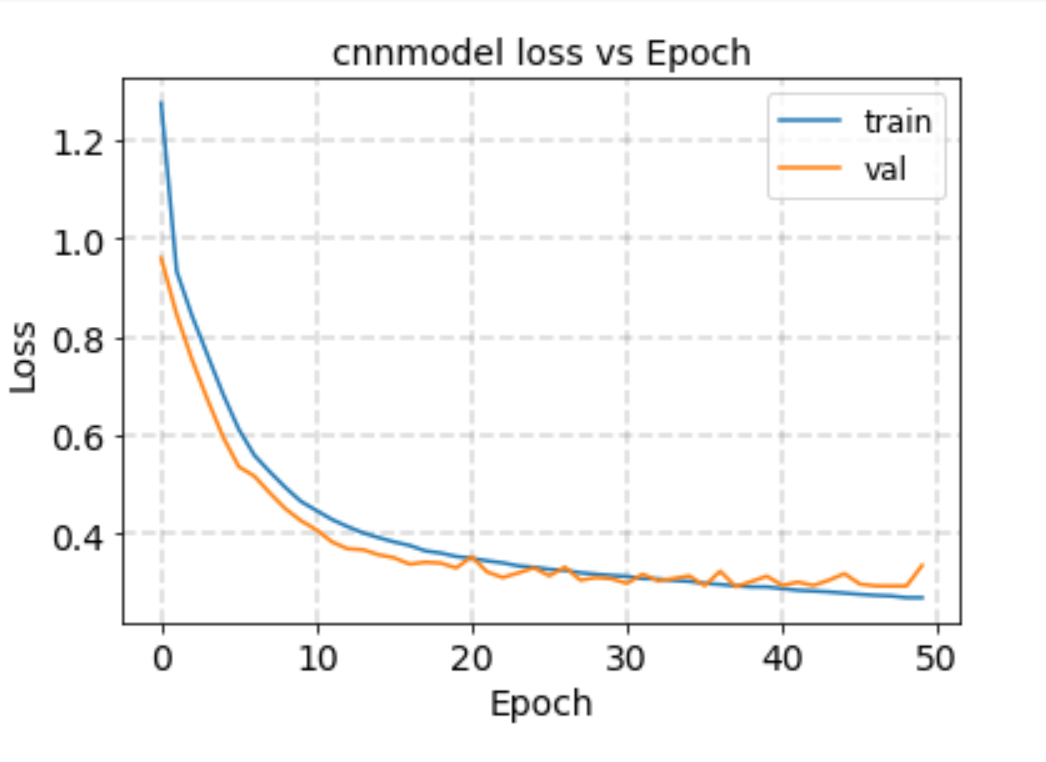

In [0]:
from IPython.display import Image
Image(filename = 'loss2.png', width=500, height=5)

In [0]:
val_loss = cnnmodel.evaluate(image_withnoise_te, label_te_scaled,verbose = 0)
print('The validation loss MSE is {:0.6f}.'.format(val_loss))

The validation loss MSE is 0.344965.


### Predicting each parameter

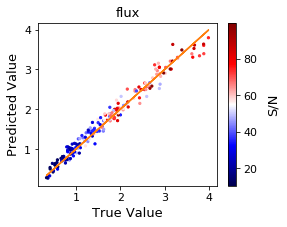

In [0]:
plot_prediction2(cnnmodel, 0)

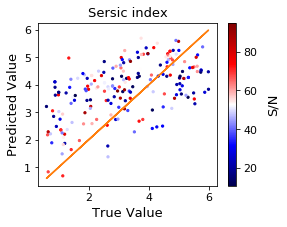

In [0]:
plot_prediction2(cnnmodel, 1)

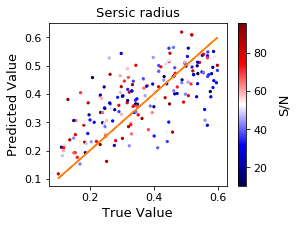

In [0]:
plot_prediction2(cnnmodel, 2)

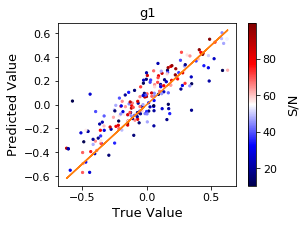

In [0]:
plot_prediction2(cnnmodel, 3)

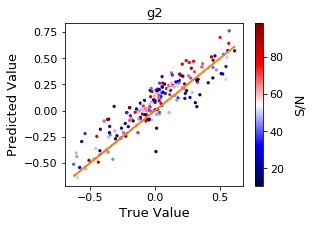

In [0]:
plot_prediction2(cnnmodel, 4)

### Estimating uncertainties and comparing to the Cramer-Rao bound

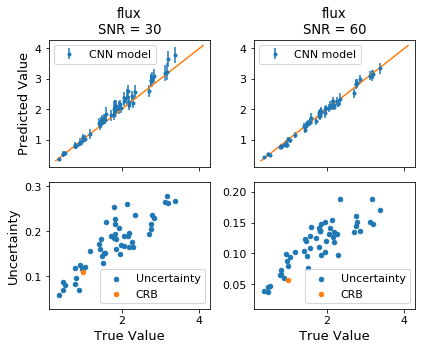

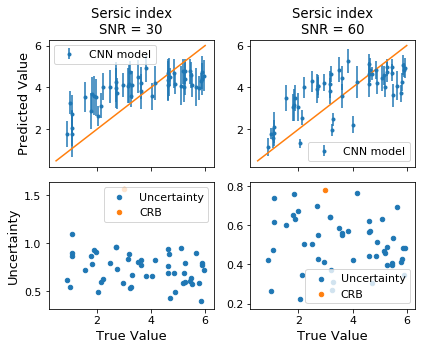

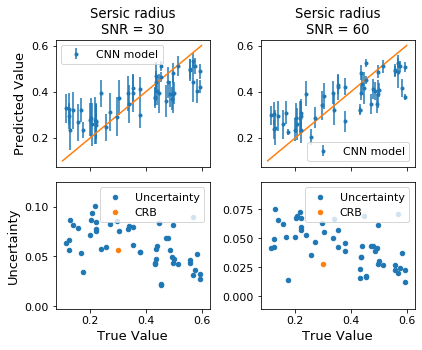

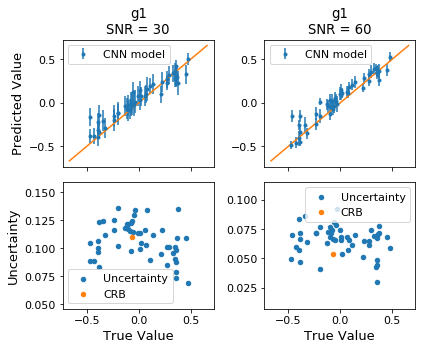

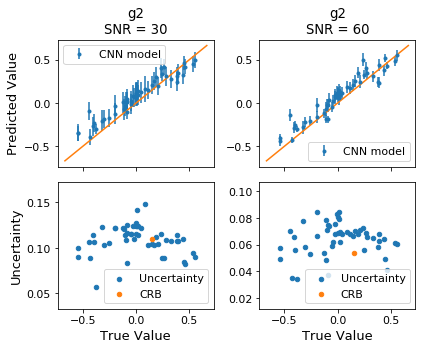

In [0]:
true_values_cnn2, mean_cnn2, sigma_cnn2 = plot_uncertainty2(cnnmodel,snr=[30,60], 
                                                            num_of_pts=num_of_pts, sampling_size = 100)

### Saving the uncertainty estimates

In [0]:
#Save the results
np.save('true_values_cnn2.npy', true_values_cnn2)
np.save('mean_cnn2.npy', mean_cnn2)
np.save('err_cnn2.npy', sigma_cnn2)

## Comparing Models

In [0]:
f= h5py.File('Data1.h5','r')
labels = f['label']
# Cramer-Rao Bound
CRB_snr30 = [[1,0.11], [3, 1.56],[0.3, 0.056], [-0.069, 0.11], [0.15, 0.11]]
CRB_snr60 = [[1,0.056], [3, 0.78],[0.3, 0.028], [-0.069, 0.054], [0.15, 0.054]]
snr = [30,60]
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']

In [0]:
# CNN model with 1 output each time, number of filters descending
true_values_cnn0 = np.load('model_uncertainty/true_values_cnn0.npy')
mean_cnn0 = np.load('model_uncertainty/mean_cnn0.npy')
err_cnn0 = np.load('model_uncertainty/err_cnn0.npy')

# CNN model with 1 output each time, number of filters ascending
true_values_cnn1 = np.load('model_uncertainty/true_values_cnn1.npy')
mean_cnn1 = np.load('model_uncertainty/mean_cnn1.npy')
err_cnn1 = np.load('model_uncertainty/err_cnn1.npy')

# CNN model with 5 outputs each time, number of filters descending
true_values_cnn2 = np.load('model_uncertainty/true_values_cnn2.npy')
mean_cnn2 = np.load('model_uncertainty/mean_cnn2.npy')
err_cnn2 = np.load('model_uncertainty/err_cnn2.npy')

#print('true_values_cnn1.shape:', true_values_cnn1.shape)
#print('mean_cnn1.shape:', mean_cnn1.shape)
#print('err_cnn1.shape:', err_cnn1.shape)
#print('true_values_cnn2.shape:', true_values_cnn2.shape)
#print('mean_cnn2.shape:', mean_cnn2.shape)
#print('err_cnn2.shape:', err_cnn2.shape)

In [0]:
def plot_uncertainty_various_models(label_ind):
    fig,ax = plt.subplots(2,2,figsize=(5.5,5), sharex = True)

    for j in range(2):
        x = np.linspace(labels[:,label_ind].min(),labels[:,label_ind].max(), 20)
        ax[0][j].errorbar(true_values_cnn0[:,label_ind], mean_cnn0[:,label_ind, j], 
                          yerr=err_cnn0[:,label_ind, j], fmt='.', markersize = 1.5,alpha = 1, label = 'CNN-0')
        ax[0][j].errorbar(true_values_cnn1[:,label_ind], mean_cnn1[:,label_ind, j], 
                          yerr=err_cnn1[:,label_ind, j], fmt='.', markersize = 0.8,alpha = 0.8,label = 'CNN-1')
        ax[0][j].errorbar(true_values_cnn2[:,label_ind], mean_cnn2[:,label_ind, j], 
                          yerr=err_cnn2[:,label_ind,j], fmt='.', markersize = 0.6,alpha = 0.6,label = 'CNN-2')
        ax[0][j].legend(fontsize = 8)
        ax[0][j].plot(x,x,'--',color = 'red', lw = 1)
        ax[0][j].set_title(label_names_list[label_ind]+'\nSNR = {}'.format(snr[j]))

        ax[1][j].scatter(true_values_cnn0[:,label_ind], err_cnn0[:,label_ind,j], s = 6, label = 'CNN-0')
        ax[1][j].scatter(true_values_cnn1[:,label_ind], err_cnn1[:,label_ind,j], s = 6, label = 'CNN-1')
        ax[1][j].scatter(true_values_cnn2[:,label_ind], err_cnn2[:,label_ind,j], s = 6, label = 'CNN-2')
        if snr[j] == 30:
            ax[1][j].scatter(CRB_snr30[label_ind][0], CRB_snr30[label_ind][1], s = 50, 
                             marker = '*', color = 'red', label = 'CRB')
        elif snr[j] == 60:
            ax[1][j].scatter(CRB_snr60[label_ind][0], CRB_snr60[label_ind][1], s = 50,  
                             marker = '*', color = 'red', label = 'CRB')
        ax[1][j].legend(fontsize = 8)
        ax[1][j].set_xlabel('True Value', fontsize = 13)

    ax[0][0].set_ylabel('Predicted Value', fontsize = 13)
    ax[1][0].set_ylabel('Uncertainty',fontsize = 13)
    plt.tight_layout()
    plt.rcParams.update({'font.size': 11})
    plt.show()

- cnn0: architecture descending # of filters, 1 output per model
- cnn1: architecture ascending # of filters, 1 output per model
- cnn2: architecture descending # of filters,5 outputs per model

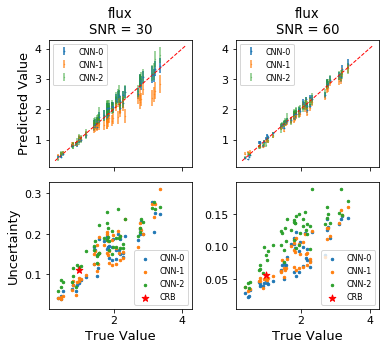

In [0]:
plot_uncertainty_various_models(0)

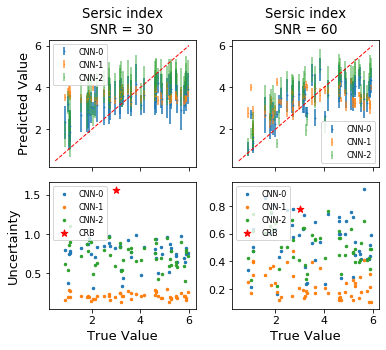

In [0]:
plot_uncertainty_various_models(1)

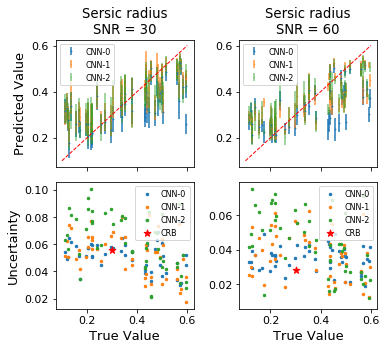

In [0]:
plot_uncertainty_various_models(2)

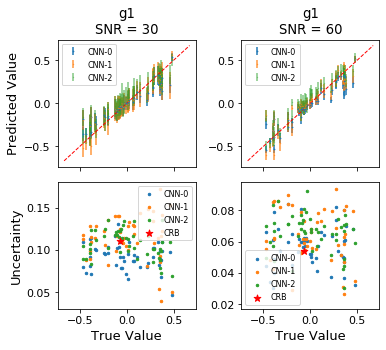

In [0]:
plot_uncertainty_various_models(3)

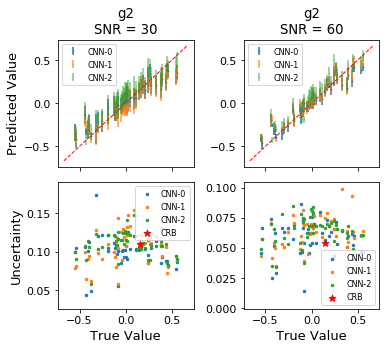

In [0]:
plot_uncertainty_various_models(4)

## Stretch Goal: Varying PSF

'What if the PSF is different from the training data"? 

#### *Examining the effects of model training on data with psf = 0.5 and model testing on data with psf = 0.5, 0.6, 0.7, 0.8, or 0.9.*


Here we present an analysis of the effects of the point spread function being different for the training and testing data. This was done as follows:

* Using the galaxy simulation routine provided, a new galaxy dataset was generated with the same number of images as our original dataset (18779), but here psf_re was set to 0.5 rather than a random number between (0.5 and 1).

* Our CNN that predicts all five parameters from an image(flux, sersic index, sersic radius , g1 and g2) was then trained on 80% of the data and tested on 20%. 

* Smaller test datasets, each consisting of 4000 images, were also generated but with psf_re set to either, 0.6, 0.7, 0.8, or 0.9.

* The trained CNN was then used to predict parameter values for each image in the smaller test sets (psf = 0.6, 0.7, 0.8, or 0.9).

* Plots were made comparing the performance of the model on data with psf = 0.5 through 0.9

* Also shown is the same analysis but with a model trained on the original data (psf_re set to a random number between 0.5 and 1.0).



Mount Google Drive to get data into Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [0]:
import sys
import math
#import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

In [0]:
# check for GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


###  Importing data

#### Importing data made with psf = 0.5 and making train and test datasets

In [0]:
# Get data generated with psf = 0.5 18799 images
label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('/content/drive/My Drive/Data05.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)
split = int(0.8*total_num)

In [0]:
# extract data and make train and test sets
np.random.seed(100)
ind = np.arange(total_num)
np.random.shuffle(ind)
train_ind = ind[0:split]
train_ind = list(np.sort(train_ind))
test_ind = ind[split:]
test_ind = list(np.sort(test_ind))
print('random indices created.')

# train dataset
image_tr = f['img'][train_ind]
#cat_tr = f['cat'][train_ind]  
label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
snr_tr = f['snr'][train_ind]
sigma_tr = f['sigma'][train_ind]
image_nonoise_tr = f['img_nonoise'][train_ind]    
image_withnoise_tr = f['img_withnoise'][train_ind]
print('training set done.')

# test dataset
image_te = f['img'][test_ind]
#cat_te = f['cat'][test_ind]  
label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
snr_te = f['snr'][test_ind]
sigma_te = f['sigma'][test_ind]
image_nonoise_te = f['img_nonoise'][test_ind]    
image_withnoise_te = f['img_withnoise'][test_ind]   
print('test set done.')

# Reshape such that the images are ready for training
image_tr = image_tr.reshape(image_tr.shape[0],64,64,1)
image_te = image_te.reshape(image_te.shape[0],64,64,1)

random indices created.
training set done.
test set done.


In [0]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

### Declaring again our CNN (5 output)

In [0]:
cnnmodel = models.Sequential()
#cnnmodel.add(GaussianNoise(30, input_shape=(64,64,1)))

cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))
cnnmodel.add(Dropout(0.1))

cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
cnnmodel.add(layers.BatchNormalization())
cnnmodel.add(layers.MaxPooling2D((2, 2)))

cnnmodel.add(layers.Flatten())
cnnmodel.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
cnnmodel.add(layers.Dense(5, activation='linear'))
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)       

In [0]:
cnnmodel.compile(loss='mse', optimizer=Adam(lr=0.0001))

### Fitting the model to the psf=0.5 training data

In [0]:
%time 
# Fit the model  
verbose, epochs = 1, 50

history = cnnmodel.fit(
      image_tr,
      label_tr_scaled,
      epochs=epochs,
      verbose=verbose,
      batch_size=64,
      shuffle=True,
      validation_data=(image_te, label_te_scaled ) )


cnnmodel.save('cnnmodel05.h5')

CPU times: user 0 ns, sys: 4 µs, total: 4 µs
Wall time: 6.91 µs
Epoch 1/50
235/235 [==============================] - 17s 72ms/step - loss: 1.1823 - val_loss: 0.8013
Epoch 2/50
235/235 [==============================] - 16s 69ms/step - loss: 0.7620 - val_loss: 0.6546
Epoch 3/50
235/235 [==============================] - 16s 68ms/step - loss: 0.6332 - val_loss: 0.5344
Epoch 4/50
235/235 [==============================] - 16s 68ms/step - loss: 0.5412 - val_loss: 0.4463
Epoch 5/50
235/235 [==============================] - 16s 68ms/step - loss: 0.4736 - val_loss: 0.4109
Epoch 6/50
235/235 [==============================] - 16s 68ms/step - loss: 0.4179 - val_loss: 0.3498
Epoch 7/50
235/235 [==============================] - 16s 68ms/step - loss: 0.3762 - val_loss: 0.3508
Epoch 8/50
235/235 [==============================] - 16s 68ms/step - loss: 0.3398 - val_loss: 0.2796
Epoch 9/50
235/235 [==============================] - 16s 68ms/step - loss: 0.3079 - val_loss: 0.2602
Epoch 10/50
235/23

In [0]:
# cnnmodel = tf.keras.models.load_model('cnnmodel05.h5')

### Plotting train and test loss

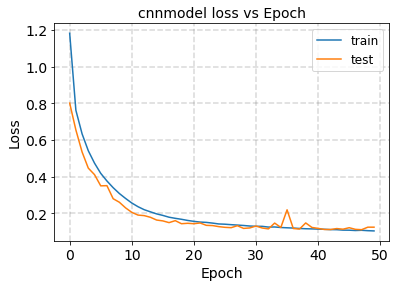

In [0]:
# plotting accuracy and loss 
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('cnnmodel loss vs Epoch', fontsize = 14)
ax.set_ylabel('Loss', fontsize = 14)
ax.set_xlabel('Epoch', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.legend(['train', 'test'], loc='best', fontsize = 12)
ax.grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)



### Getting test data 

#### Getting test data for psfs = 0.6, 0.7, 0.8, and 0.9
Data were made in a separatre notebook by setting psf_re in the galaxy generating program provided to the indicated value and simulating 4000 galaxies

In [0]:
f06= h5py.File('/content/drive/My Drive/Data06.h5','r')
f07= h5py.File('/content/drive/My Drive/Data07.h5','r')
f08= h5py.File('/content/drive/My Drive/Data08.h5','r')
f09= h5py.File('/content/drive/My Drive/Data09.h5','r')

In [0]:
# extract data 
image_06= f06['img'][:]
label_06 = f06['label'][:]
snr_06 = f06['snr'][:]
image_07 = f07['img'][:]
label_07 = f07['label'][:]
snr_07 = f07['snr'][:]
image_08 = f08['img'][:]
label_08 = f08['label'][:]
snr_08 = f08['snr'][:]
image_09 = f09['img'][:]
label_09 = f09['label'][:]
snr_09 = f09['snr'][:]

In [0]:
# reshape images for making model predictions
image_06_e = image_06.reshape(image_06.shape[0],64,64,1)
image_07_e = image_07.reshape(image_07.shape[0],64,64,1)
image_08_e = image_08.reshape(image_08.shape[0],64,64,1)
image_09_e = image_09.reshape(image_09.shape[0],64,64,1)

### Making predictions on each set of test data

In [0]:
single_scaler = StandardScaler()
single_scaler.fit(label_tr)

label_pred_scaled05 = cnnmodel.predict(image_te)
label_pred05 = single_scaler.inverse_transform(label_pred_scaled05)
label_pred_scaled06 = cnnmodel.predict(image_06_e)
label_pred06 = single_scaler.inverse_transform(label_pred_scaled06)
label_pred_scaled07 = cnnmodel.predict(image_07_e)
label_pred07 = single_scaler.inverse_transform(label_pred_scaled07)
label_pred_scaled08 = cnnmodel.predict(image_08_e)
label_pred08 = single_scaler.inverse_transform(label_pred_scaled08)
label_pred_scaled09 = cnnmodel.predict(image_09_e)
label_pred09 = single_scaler.inverse_transform(label_pred_scaled09)

### Plotting predicted vs true value

#### Plotting predicted vs true value for each set of test data (psf = 0.5, 0.6, 0.7, 0.8, 0.9) for 200 random points.

In [0]:
# function to help with plotting
def plot_prediction_wpsf(image_te, label_te, snr_te, cnnmodel, label_ind, num_of_pts = 200, psf = 0, a=0, yy=True, bar=False):

    indices = np.random.randint(0,image_te.shape[0],num_of_pts)
    single_scaler = StandardScaler()
    single_scaler.fit(label_tr)
    label_pred_scaled = cnnmodel.predict(image_te[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)
    ax[a].scatter(label_te[indices,label_ind],label_pred[:, label_ind], 
                c = snr_te[indices], cmap="seismic", s = 20)
    ax[a].plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')
    ax[a].set_xlabel('True Value', fontsize = 13)
    if yy == True:
      ax[a].set_ylabel('Predicted Value', fontsize = 13)
    else:
      ax[a].set_yticks([])
    ax[a].set_title(label_names_list[label_ind] +' psf = '+ str(psf), fontsize = 13)
    if bar == True:
      clb = plt.colorbar(plt.cm.ScalarMappable( cmap="seismic"), ax=ax[a])
      clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)


*Plotting Fluxes*

In [0]:
imgs = [image_te, image_06_e, image_07_e, image_08_e, image_09_e]
snrs = [snr_te, snr_06, snr_07, snr_08, snr_09]
labels = [label_te, label_06, label_07, label_08, label_09]

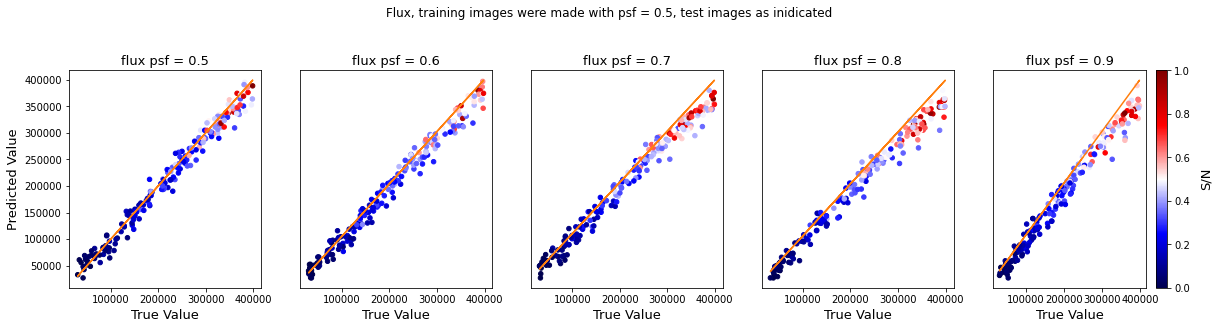

In [0]:
# Plotting Fluxes vs psf
parmam_num = 0 
fig, ax = plt.subplots(1,5, figsize=(20,4))
plot_prediction_wpsf(imgs[0], labels[0], snrs[0], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.5, a=0)
plot_prediction_wpsf(imgs[1], labels[1], snrs[1], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.6, a=1, yy=False)
plot_prediction_wpsf(imgs[2], labels[2], snrs[2], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.7, a=2, yy=False)
plot_prediction_wpsf(imgs[3], labels[3], snrs[3], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.8, a=3, yy=False)
plot_prediction_wpsf(imgs[4], labels[4], snrs[4], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.9, a=4, yy=False, bar=True)
plt.suptitle('Flux, training images were made with psf = 0.5, test images as inidicated', y=1.1)
plt.show()


#### Comment
* As the psf value used in the testing data increases, the corrleation between predicted and true flux grows a little worse particularly at high flux values, but still not bad.

*Plotting Sersic index*

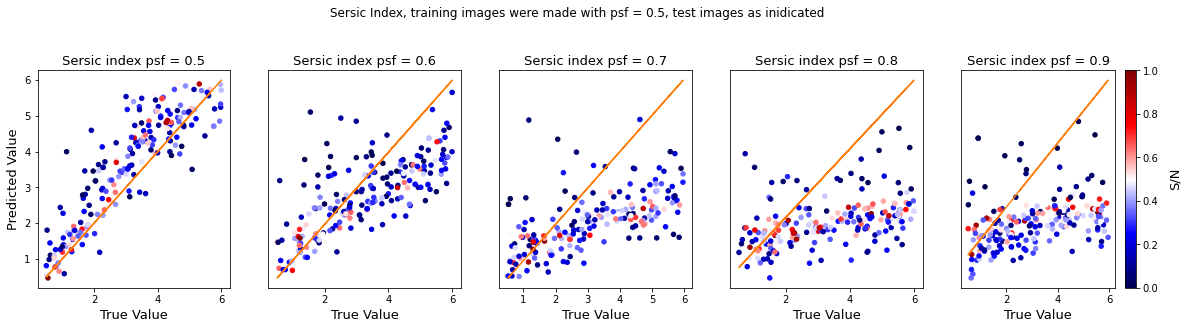

In [0]:
# Plotting Sersic vs psf
parmam_num = 1 
fig, ax = plt.subplots(1,5, figsize=(20,4))
plot_prediction_wpsf(imgs[0], labels[0], snrs[0], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.5, a=0)
plot_prediction_wpsf(imgs[1], labels[1], snrs[1], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.6, a=1, yy=False)
plot_prediction_wpsf(imgs[2], labels[2], snrs[2], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.7, a=2, yy=False)
plot_prediction_wpsf(imgs[3], labels[3], snrs[3], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.8, a=3, yy=False)
plot_prediction_wpsf(imgs[4], labels[4], snrs[4], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.9, a=4, yy=False, bar=True)
plt.suptitle('Sersic Index, training images were made with psf = 0.5, test images as inidicated', y=1.1)
plt.show()

#### Comment
* As the psf value used in the testing data increases, the corrleation between predicted and true sersic index grows steadily worse. As the psf increases the model under-predicts the true value and the effect is worse at high values, such that the model's predictions become flat below the true line.

*Plotting Sersic radius*

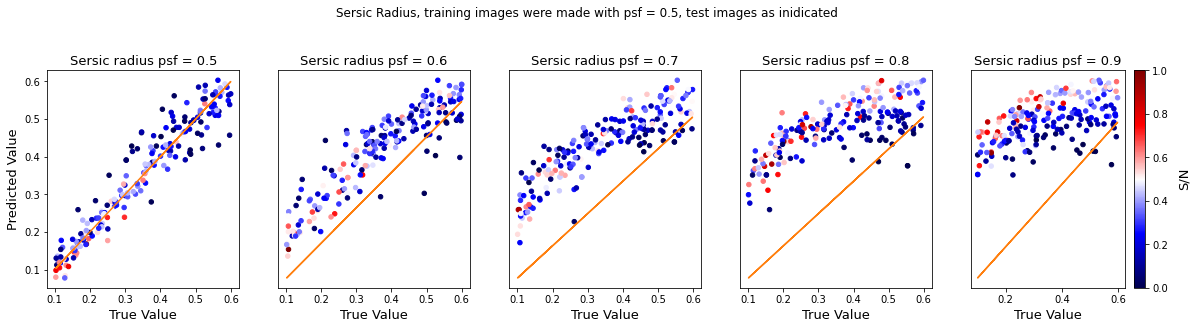

In [0]:
# Plotting Sersic radius vs psf
parmam_num = 2 
fig, ax = plt.subplots(1,5, figsize=(20,4))
plot_prediction_wpsf(imgs[0], labels[0], snrs[0], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.5, a=0)
plot_prediction_wpsf(imgs[1], labels[1], snrs[1], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.6, a=1, yy=False)
plot_prediction_wpsf(imgs[2], labels[2], snrs[2], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.7, a=2, yy=False)
plot_prediction_wpsf(imgs[3], labels[3], snrs[3], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.8, a=3, yy=False)
plot_prediction_wpsf(imgs[4], labels[4], snrs[4], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.9, a=4, yy=False, bar=True)
plt.suptitle('Sersic Radius, training images were made with psf = 0.5, test images as inidicated', y=1.1)
plt.show()

#### Comment
* As the psf value used in the testing data increases, the corrleation between predicted and true sersic radius grows steadily worse. As the psf increased the model over-predicts the true value and the effect is worse at high values, such that the model's predictions become flat above the true line.

*Plotting g1*

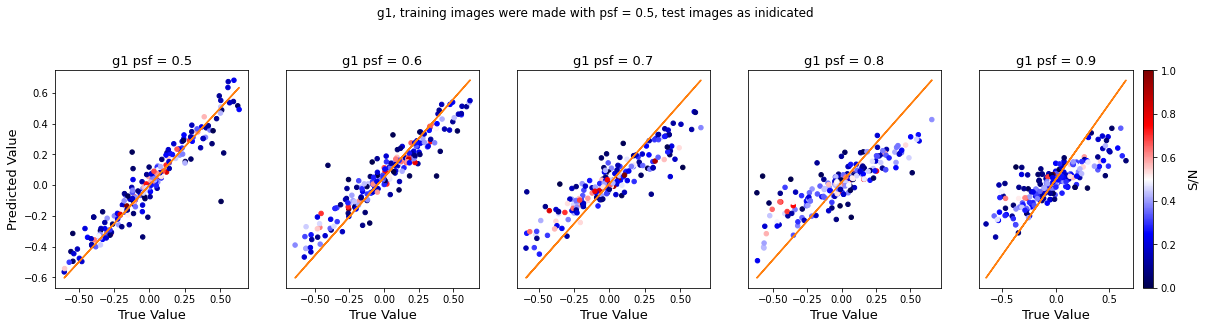

In [0]:
# Plotting g1 vs psf
parmam_num = 3 
fig, ax = plt.subplots(1,5, figsize=(20,4))
plot_prediction_wpsf(imgs[0], labels[0], snrs[0], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.5, a=0)
plot_prediction_wpsf(imgs[1], labels[1], snrs[1], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.6, a=1, yy=False)
plot_prediction_wpsf(imgs[2], labels[2], snrs[2], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.7, a=2, yy=False)
plot_prediction_wpsf(imgs[3], labels[3], snrs[3], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.8, a=3, yy=False)
plot_prediction_wpsf(imgs[4], labels[4], snrs[4], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.9, a=4, yy=False, bar=True)
plt.suptitle('g1, training images were made with psf = 0.5, test images as inidicated', y=1.1)
plt.show()

#### Comment
* As the psf value used in the testing data increases, the corrleation between predicted and true g1 grows steadily worse. As the psf increases the model under-predicts the true value at high g1 values and it over-predicts and true value at low g1 values. This makes the data flatter relative to the true line, but still centered.

*Plotting g2*

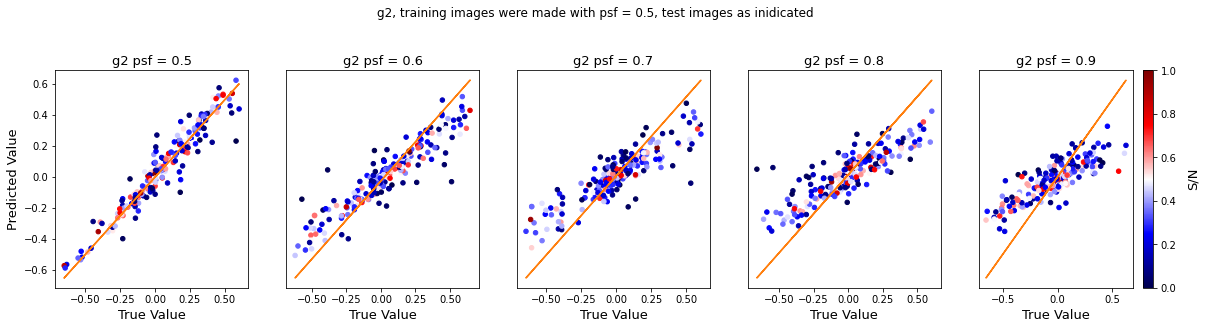

In [0]:
# Plotting g2 vs psf
parmam_num = 4 
fig, ax = plt.subplots(1,5, figsize=(20,4))
plot_prediction_wpsf(imgs[0], labels[0], snrs[0], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.5, a=0)
plot_prediction_wpsf(imgs[1], labels[1], snrs[1], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.6, a=1, yy=False)
plot_prediction_wpsf(imgs[2], labels[2], snrs[2], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.7, a=2, yy=False)
plot_prediction_wpsf(imgs[3], labels[3], snrs[3], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.8, a=3, yy=False)
plot_prediction_wpsf(imgs[4], labels[4], snrs[4], cnnmodel, parmam_num, num_of_pts = 200, psf = 0.9, a=4, yy=False, bar=True)
plt.suptitle('g2, training images were made with psf = 0.5, test images as inidicated', y=1.1)
plt.show()

### Comment
* As with g1, as the psf value used in the testing data increases, the corrleation between predicted and true g2 grows steadily worse. As the psf increases the model under-predicts the true value at high g2 values and it over-predicts the true value at low g2 values. This makes the data flatter relative to the true line, but still centered.

### Plotting mean squared error

#### Plotting mean squared error as a function of psf for each parameter

*Getting MSE for each parameter at each psf*

In [0]:
# measuring mse for each parameter
from sklearn.metrics import mean_squared_error
label_05 = label_te
mse_05 = []
mse_06 = []
mse_07 = []
mse_08 = []
mse_09 = []
for i in range(5):
  mse_05.append(mean_squared_error(label_05[:, i], label_pred05[:, i]))
  mse_06.append(mean_squared_error(label_06[:, i], label_pred06[:, i]))
  mse_07.append(mean_squared_error(label_07[:, i], label_pred07[:, i]))
  mse_08.append(mean_squared_error(label_08[:, i], label_pred08[:, i]))
  mse_09.append(mean_squared_error(label_09[:, i], label_pred09[:, i]))

mse_list = [mse_05, mse_06, mse_07, mse_08, mse_09]
fluxes = []
indices = []
radii = []
g1s = []
g2s = []
for i in range(5):
    fluxes.append(mse_list[i][0])
    indices.append(mse_list[i][1])
    radii.append(mse_list[i][2])
    g1s.append(mse_list[i][3])
    g2s.append(mse_list[i][4])

*Making MSE plots*

Text(0.5, 0.98, 'MSE for each Parameter as a function of PSF')

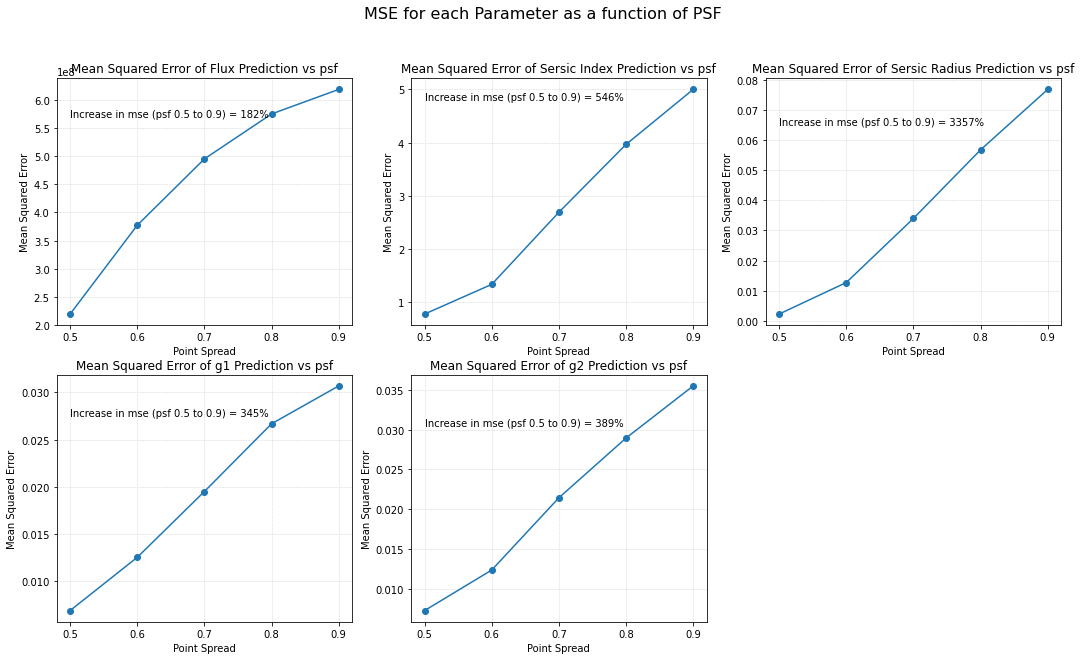

In [0]:
plt.figure(figsize=(18,10))
psfs = [0.5, 0.6, 0.7, 0.8, 0.9]

plt.subplot(2,3,1)
plt.plot(psfs, fluxes, marker='o', markersize=6, linestyle='-')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Flux Prediction vs psf')
plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(fluxes[-1]-fluxes[0])/fluxes[0]):.0f}%', (0.5, 0.57e9))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.subplot(2,3,2)
plt.plot(psfs, indices, marker='o', markersize=6, linestyle='-')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Sersic Index Prediction vs psf')
plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(indices[-1]-indices[0])/indices[0]):.0f}%', (0.5, 4.8))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.subplot(2,3,3)
plt.plot(psfs, radii, marker='o', markersize=6, linestyle='-')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Sersic Radius Prediction vs psf')
plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(radii[-1]-radii[0])/radii[0]):.0f}%', (0.5, 0.065))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.subplot(2,3,4)
plt.plot(psfs, g1s, marker='o', markersize=6, linestyle='-')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of g1 Prediction vs psf')
plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(g1s[-1]-g1s[0])/g1s[0]):.0f}%', (0.5, 0.0275))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.subplot(2,3,5)
plt.plot(psfs, g2s, marker='o', markersize=6, linestyle='-')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of g2 Prediction vs psf')
plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(g2s[-1]-g2s[0])/g2s[0]):.0f}%', (0.5, 0.0305))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)

plt.suptitle('MSE for each Parameter as a function of PSF', fontsize = 16)
plt.show()

### Comment
* As the psf value used in the testing data increases, for each parameter the means squared error grows, but in percentage terms by different amounts.

* Thus, overall a mismatch between the psf in the training and the testing data can severaly degrade model performance. There is an approximately linear decline in performance, as judged by mse, as the test psf increases away from the training value.

### Our model trained on the original data 

#### Question: What if the model was trained on our original data whose simulated galaxies had psf values randomly ranging from 0.5 to 1.0? Would changing values of psf in the test data still have such profound effects? 

* To address this questions, we re ran the above analysis but with a model trained on our original data set. The results are below.

#### Here are the same figures but for the case where the model was trained on the original dataset with psf varying between 0.5 and 1.0.

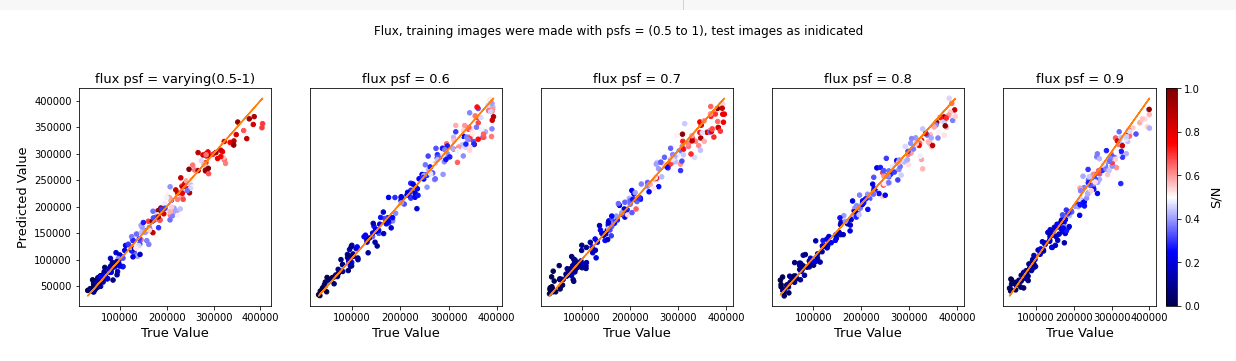

In [0]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/fluxes.png')

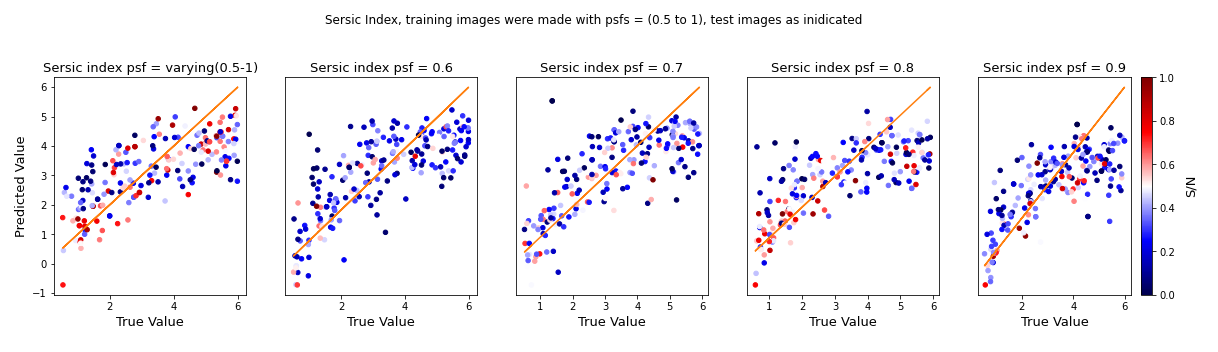

In [0]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/Index.png')

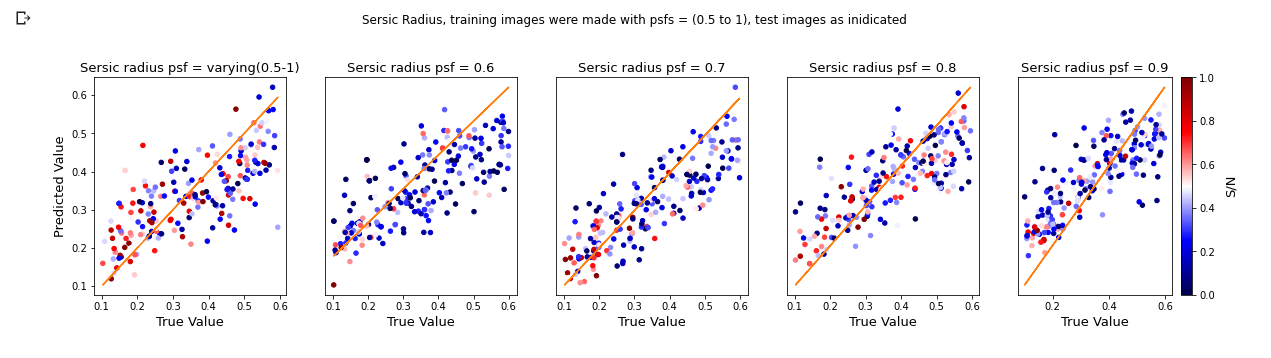

In [0]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/radii.png')

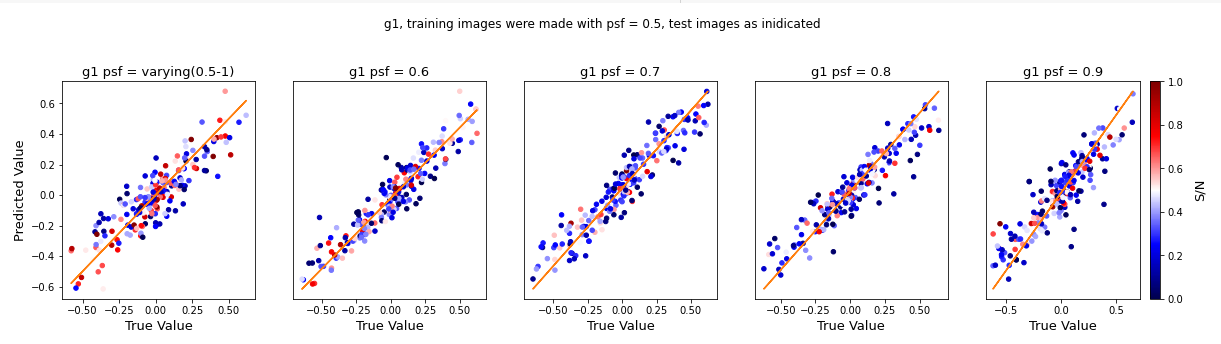

In [0]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/g1s.png')

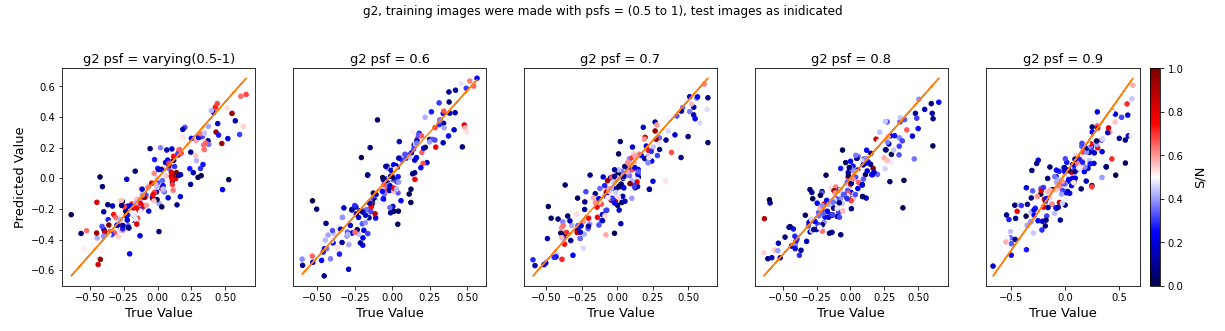

In [0]:
from IPython.display import Image
Image(filename = '/content/drive/My Drive/g2s.png')

#### Comment

* As is evident, the effects of the different psfs in the testing data are now much less severe than when the model was trained on data with a single psf(0.5).

### Now looking again at MSE for each parameter vs psf

In [0]:
import pickle
with open ('/content/drive/My Drive/s_file1', 'rb') as fp:
  fluxes2 = pickle.load(fp)
with open ('/content/drive/My Drive/s_file2', 'rb') as fp:
  indices2 = pickle.load(fp)
with open ('/content/drive/My Drive/s_file3', 'rb') as fp:
  radii2 = pickle.load(fp)
with open ('/content/drive/My Drive/s_file4', 'rb') as fp:
  g1s2 = pickle.load(fp)
with open ('/content/drive/My Drive/s_file5', 'rb') as fp:
  g2s2 = pickle.load(fp)

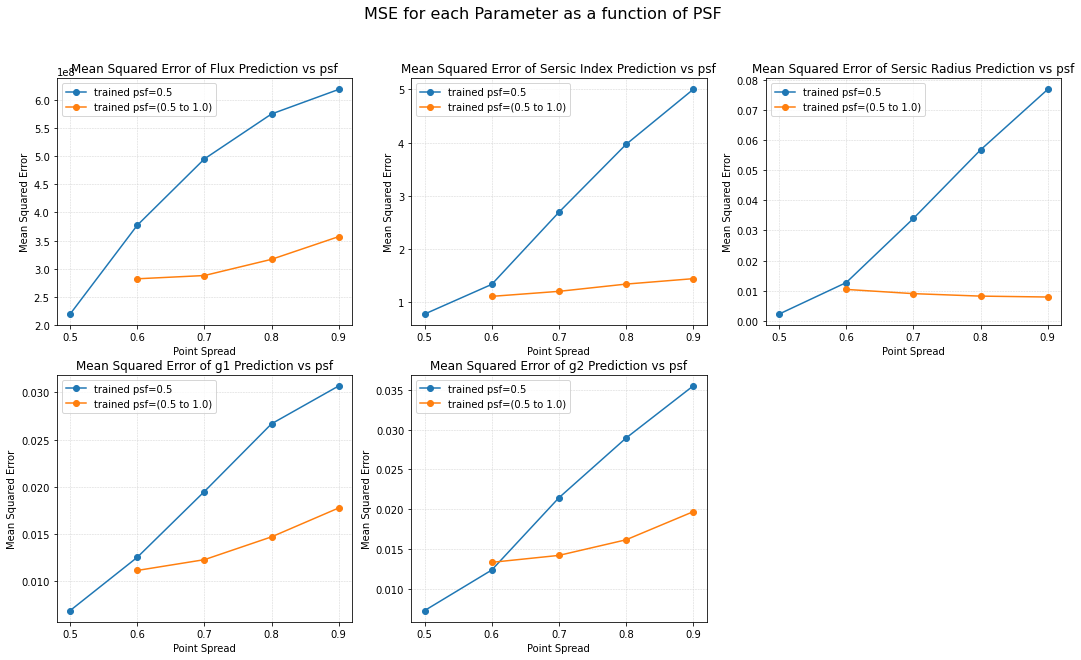

In [0]:
plt.figure(figsize=(18,10))
psfs = [0.5, 0.6, 0.7, 0.8, 0.9]

plt.subplot(2,3,1)
plt.plot(psfs, fluxes, marker='o', markersize=6, linestyle='-', label='trained psf=0.5')
plt.plot(psfs[1:], fluxes2[1:], marker='o', markersize=6, linestyle='-', label='trained psf=(0.5 to 1.0)')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Flux Prediction vs psf')
#plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(fluxes[-1]-fluxes[0])/fluxes[0]):.0f}%', (0.5, 0.57e9))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(2,3,2)
plt.plot(psfs, indices, marker='o', markersize=6, linestyle='-', label='trained psf=0.5')
plt.plot(psfs[1:], indices2[1:], marker='o', markersize=6, linestyle='-', label='trained psf=(0.5 to 1.0)')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Sersic Index Prediction vs psf')
#plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(indices[-1]-indices[0])/indices[0]):.0f}%', (0.5, 4.8))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(2,3,3)
plt.plot(psfs, radii, marker='o', markersize=6, linestyle='-', label='trained psf=0.5')
plt.plot(psfs[1:], radii2[1:], marker='o', markersize=6, linestyle='-', label='trained psf=(0.5 to 1.0)')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of Sersic Radius Prediction vs psf')
#plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(radii[-1]-radii[0])/radii[0]):.0f}%', (0.5, 0.065))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(2,3,4)
plt.plot(psfs, g1s, marker='o', markersize=6, linestyle='-', label='trained psf=0.5')
plt.plot(psfs[1:], g1s2[1:], marker='o', markersize=6, linestyle='-', label='trained psf=(0.5 to 1.0)')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of g1 Prediction vs psf')
#plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(g1s[-1]-g1s[0])/g1s[0]):.0f}%', (0.5, 0.0275))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(2,3,5)
plt.plot(psfs, g2s, marker='o', markersize=6, linestyle='-', label='trained psf=0.5')
plt.plot(psfs[1:], g2s2[1:], marker='o', markersize=6, linestyle='-', label='trained psf=(0.5 to 1.0)')
plt.xlabel('Point Spread')
plt.xticks(psfs)
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error of g2 Prediction vs psf')
#plt.annotate(f'Increase in mse (psf 0.5 to 0.9) = {(100*(g2s[-1]-g2s[0])/g2s[0]):.0f}%', (0.5, 0.0305))
plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
plt.legend()

plt.suptitle('MSE for each Parameter as a function of PSF', fontsize = 16)
plt.show()

### PSF analysis conclusion

* In the plots above we see in yellow that when the model is trained on a images with a variety of psfs, the model's performance does not degrade nearly as much as a function of test psf as the model trained with images all with psf = 0.5.


* The take home message here seems to be: If you want to use a model on data taken from different telescopes with different point spread functions, then you should incoroprate this variability into the training data; otherwise, the model is likely to do poorly on images taken with psfs even just moderately far from the training psf.

## Strech Goal: Off-center Galaxies

Here we seek to understand how the CNN model (5 output nodes) that we have trained on the galsim data handles slight perterbations in galaxy alignment—that is, if the images are moved randomly off-center so as to imulate random error in the telescope's attempts to center on a distant galaxy. 

Overall we find, unsuprisingly, that, assuming that this type of error will indeed exist, it makes the network much more robust if we train on perturbed data rather than on perfectly centered data.

#### Import libraries

In [0]:
import sys
import math
#import galsim
import matplotlib.pyplot as plt
import h5py
import numpy as np 
import random 
import copy 
import time
import seaborn as sns
from tqdm.notebook import trange, tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GaussianNoise
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.set_printoptions(threshold=sys.maxsize)

In [0]:
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, \
                UpSampling2D, Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.optimizers import Adam
from  tensorflow.keras.layers import UpSampling2D

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib as mpl
from tensorflow.keras import metrics

from tqdm.notebook import trange, tqdm
from time import sleep
import multiprocessing
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import concatenate as TC
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

# Plotting libraries
import matplotlib.pyplot as plt
plt.gray()

<Figure size 432x288 with 0 Axes>

**Helper Functions**



In [0]:
# Evaluation. modified from Ziwei's function
def plot_prediction(cnnmodel, label_ind, ax, num_of_pts = 200):

    indices = np.random.randint(0,image_te.shape[0],num_of_pts)
    #single_scaler = MinMaxScaler()
    single_scaler = StandardScaler()
    #single_scaler.fit(np.expand_dims(label_tr,axis=1))
    single_scaler.fit(label_tr)

    label_pred_scaled = cnnmodel.predict(image_te[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)

    fig= plt.figure(figsize=(5,4))
    ax.scatter(label_te[indices,label_ind],label_pred[:, label_ind], 
                c = snr_te[indices], cmap="seismic", s = 20)
    ax.plot(label_te[indices,label_ind], label_te[indices,label_ind], color = 'tab:orange')

    ax.xlabel('True Value', fontsize = 13)
    ax.ylabel('Predicted Value', fontsize = 13)
    ax.settitle(label_names_list[label_ind], fontsize = 13)

    clb = plt.colorbar()
    clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    plt.show()

def plot_uncertainty2(cnnmodel, snr=[30,60], num_of_pts=50, sampling_size = 100):
    '''For the model with 5 outputs'''
    np.random.seed(200)
    indices = np.random.randint(0,image_withnoise_te.shape[0],num_of_pts)
    true_values = label_te[indices]
    mean = np.zeros([num_of_pts, 5, 2])
    sigma = np.zeros([num_of_pts, 5, 2])
    label_pred = np.zeros([num_of_pts, sampling_size, 5, 2])
       
    CRB_snr30 = [[1,0.11], [3, 1.56],[0.3, 0.056], [-0.069, 0.11], [0.15, 0.11]]
    CRB_snr60 = [[1,0.056], [3, 0.78],[0.3, 0.028], [-0.069, 0.054], [0.15, 0.054]]
    
    for j in range(2):
        i = 0
        for idx in indices:
            mean[i,:,j], sigma[i,:,j], label_pred_temp = get_uncertainty2(cnnmodel, image_nonoise_te[idx], 
                                                                  snr[j], size=sampling_size)
            label_pred[i,:,:,j] = label_pred_temp
            i+=1
    
    for label_ind in range(5):
        x = np.linspace(label_te[:,label_ind].min(),label_te[:,label_ind].max(),20)
        fig,ax = plt.subplots(2,2,figsize=(6,5), sharex = True)
        for j in range(2):
            ax[0][j].set_title(label_names_list[label_ind]+'\nSNR = {}'.format(snr[j]))
            ax[0][j].errorbar(true_values[:,label_ind], mean[:,label_ind,j], 
                              yerr=sigma[:,label_ind,j], fmt='.', label = 'CNN model')
            ax[0][j].legend()
            ax[0][j].plot(x,x,color = 'tab:orange')
            ax[1][j].scatter(true_values[:,label_ind], sigma[:,label_ind,j], s = 20, label = 'Uncertainty')
            if snr[j] == 30:
                ax[1][j].scatter(CRB_snr30[label_ind][0], CRB_snr30[label_ind][1], s = 20, label = 'CRB')
            elif snr[j] == 60:
                ax[1][j].scatter(CRB_snr60[label_ind][0], CRB_snr60[label_ind][1], s = 20, label = 'CRB')
            ax[1][j].set_xlabel('True Value', fontsize = 13)
            ax[1][j].legend()

        ax[0][0].set_ylabel('Predicted Value', fontsize = 13)
        ax[1][0].set_ylabel('Uncertainty',fontsize = 13)
        plt.tight_layout()
        plt.rcParams.update({'font.size': 11})
        plt.show()
        
    return true_values, mean, sigma

def randomly_decenter(img,  pixel_amt = 2, plott = False, direction = "random", verbose = False):
    
    img_orig = img

    random_movements = list(np.random.binomial(n=min(pixel_amt, 15), p = 0.3, size = 4)) 
    
    left =  -random_movements[0]   #(-)
    right =  random_movements[1]  #(+)
    down =  -random_movements[2]   #(-)
    up =     random_movements[3]     #(+)

    lateral  = right + left
    vertical = up    + down

    if lateral <= 0: #move left
        pixel_amt = -lateral
        if pixel_amt == 1:
            cut_noise = img[:,0].reshape(64,1)
        else:
            cut_noise = img[:, 0: pixel_amt]
        img  = img[:, pixel_amt:64]
        img  = np.concatenate([img, cut_noise],axis = 1) # left
    
    if lateral > 0: # move right

        pixel_amt = lateral

        if pixel_amt == 1:
            cut_noise = img[:,63].reshape(64,1)
        else:
            cut_noise = img[:, (64-pixel_amt):64]
        img  = img[:, 0: (64 - pixel_amt)]
        img  = np.concatenate([cut_noise, img],axis = 1) # right
        
    if vertical < 0: # down
        pixel_amt = -vertical
        if pixel_amt == 1:
            cut_noise = img[63].reshape(1,64)
        else:
            cut_noise = img[(64-pixel_amt):64]
        img  = img[0:(64-pixel_amt)]
        img  = np.concatenate([cut_noise, img ],axis = 0) # down

    if vertical > 0:
        pixel_amt = vertical
        if pixel_amt == 1:
            cut_noise = img[0].reshape(1,64)
        else:
            cut_noise = img[0:pixel_amt]
        img  = img[pixel_amt:64]
        img  = np.concatenate([img, cut_noise],axis = 0) # up

    cmap = sns.cubehelix_palette(start=2.9, light=0.9, as_cmap=True, reverse=True)
    if plott == True:
        fig, ax = plt.subplots(1,2, figsize = (15,6))
        ax = ax.flatten()
        #ax[0].imshow(img_orig)
        #ax[1].imshow(img)
        sns.heatmap(img_orig, cmap = cmap, ax = ax[0])
        sns.heatmap(img_orig, cmap = cmap, ax = ax[1])


    if verbose == True:
        print(random_movements)
        print(lateral)
        print(vertical)
    
    return(img)

#for i in trange
def decenter_dataset(arr):

    for i in trange(arr.shape[0], desc='processing images...'): #range(image_tr.shape[0])
        img_ = arr[i,:,:,:].reshape(64,64)
        img_adj = randomly_decenter(img_, 15, False, "all")
        img_adj = img_adj.reshape(1,64,64,1)
        if i == 0:
            new_dataset = img_adj
        else:
            new_dataset = np.concatenate([new_dataset, img_adj ],axis = 0)
    return(new_dataset)

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


###  Importing data and making train and test datasets

**The 'label' in the data set is a concatenate of physical parameters (flux, sersic index, sersic radius, g1, g2). g1 and g2 are reduced shear, reparametrization of the ellipticity and orientation. g1= (1-q)/(1+q) cos phi and g2= (1-q)/(1+q) sin phi, where q is ellipticity and phi is orientation. ***

Here is literature: http://2017.ds3-datascience-polytechnique.fr/wp-content/uploads/2017/08/DS3_posterID_012.pdf

In [0]:
%time 
import h5py
resplit = True

label_names_list = ['flux', 'Sersic index', 'Sersic radius', 'g1', 'g2']
f= h5py.File('./drive/Shared drives/galaxy/Data1.h5','r')
total_num = f['img'][:].shape[0]
print('total number of images:',total_num)


if resplit == True:
  
  split = int(0.8*total_num)
  np.random.seed(100)
  ind = np.arange(total_num)
  np.random.shuffle(ind)
  train_ind = ind[0:split]
  train_ind = list(np.sort(train_ind))
  test_ind = ind[split:]
  test_ind = list(np.sort(test_ind))
  print('random indices created.')

  # train dataset
  image_tr = f['img'][train_ind]
  cat_tr = f['cat'][train_ind]  
  label_tr = f['label'][train_ind]   # this gives the set of parameters that characterize the galaxy 
  snr_tr = f['snr'][train_ind]
  sigma_tr = f['sigma'][train_ind]
  image_nonoise_tr = f['img_nonoise'][train_ind]    
  image_withnoise_tr = f['img_withnoise'][train_ind]
  print('training set done.')

  # test dataset
  image_te = f['img'][test_ind]
  cat_te = f['cat'][test_ind]  
  label_te = f['label'][test_ind]   # this gives the set of parameters that characterize the galaxy 
  snr_te = f['snr'][test_ind]
  sigma_te = f['sigma'][test_ind]
  image_nonoise_te = f['img_nonoise'][test_ind]    
  image_withnoise_te = f['img_withnoise'][test_ind]   
  print('test set done.')

  # Reshape such that the images are ready for training
  image_tr = image_withnoise_tr.reshape(image_tr.shape[0],64,64,1)
  image_te = image_withnoise_te.reshape(image_te.shape[0],64,64,1)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
total number of images: 18779
random indices created.
training set done.
test set done.


In [0]:
# Rescale the labels
# Standardize to normal(0,1)
standard_scaler = StandardScaler()
standard_scaler.fit(label_tr)
label_tr_scaled = standard_scaler.transform(label_tr)
label_te_scaled = standard_scaler.transform(label_te)

### Looking at perturbed galaxies

#### Here we see the function at work, the perturbations are barely noticable to the eye, which is exactly how a powerful telescope might make errors.

The error for each picture composed of 4 samples from a binomial distribution (representing the 4 directions) and the up and right r.v.'s were multiplied by one while the down and left r.v.s were multiplied by -1. The noise at the edge of the images was spliced and re-pasted, which we felt was justified because the movements of the galaxy centers was limited and we likely cut and pasted mostly dark pixels.



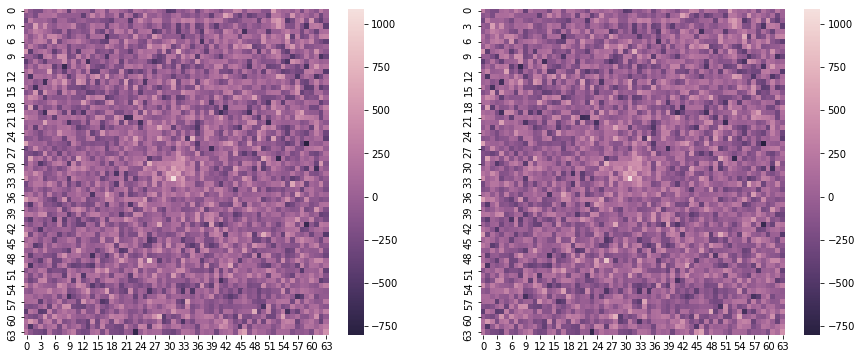

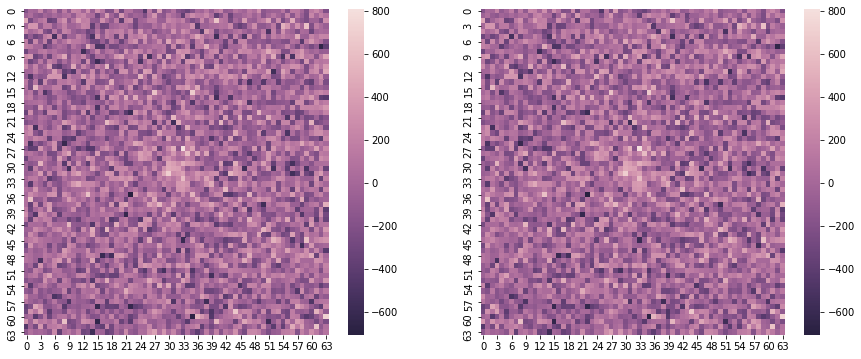

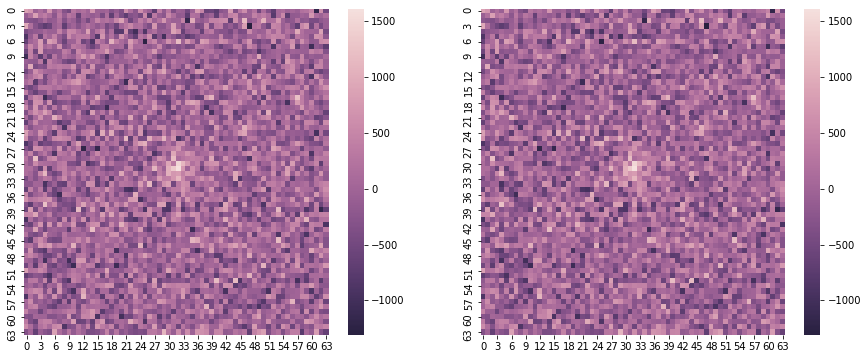

In [0]:
#cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    
import seaborn as sns
#row
image_0 = image_tr[0,:,:,:].reshape(64,64)

for i in range(3):
  hi =randomly_decenter(image_tr[i,:,:,:].reshape(64,64),pixel_amt = 30, plott = True)

#################################################

In [0]:
if resplit == True:
  % rm /content/drive/Shared\ drives/galaxy/decentered.h5
  % ls /content/drive/Shared\ drives/galaxy


 0CNN_Galaxy_Joy.ipynb
 CNN_Galaxy_Cox.ipynb
 CNN_Galaxy_Ziwei_new.ipynb
 cnnmodel1.h5
 cnnmodel1_weights.h5
 cnnmodel2.h5
 cnnmodel2_weights.h5
 cnnmodel_flux_imprvd.h5
 cnnmodel_flux_v0.h5
 cnnmodel_g1_imprvd.h5
 cnnmodel_g1_v0.h5
 cnnmodel_g2_imprvd.h5
 cnnmodel_g2_v0.h5
 cnnmodel_index_imprvd2.h5
 cnnmodel_index_imprvd.h5
 cnnmodel_index_v0.h5
 cnnmodel_radius_imprvd.h5
 cnnmodel_radius_v0.h5
 Cramer_Rao_table.xlsx
'CS109b-2020-lec2_modified(with CRB table corrected).pdf'
 Data05.h5
 Data06.h5
 Data07.h5
 Data08.h5
 Data09.h5
 Data1.h5
 Model_Comparison_new.ipynb
 model_uncertainty/
'Point Spread Function Analysis.ipynb'
'Project Pres Template Cox.pptx'


In [0]:
# build perterbed train and test sets.

if resplit == True:
  image_tr_decentered = decenter_dataset(image_tr)
  image_te_decentered = decenter_dataset(image_te)



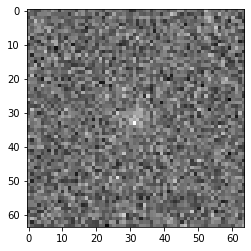

In [0]:
plt.imshow(image_tr[0,:,:,:].reshape(64,64))

In [0]:
if resplit == True:
  with h5py.File('./drive/Shared drives/galaxy/decentered.h5') as hdf:
      hdf.create_dataset('train_images', data = image_tr)
      hdf.create_dataset('test_images',  data = image_te)
      hdf.create_dataset("train_labels", data = label_tr_scaled)
      hdf.create_dataset("test_labels",  data = label_te_scaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [0]:
% ls /content/drive/Shared\ drives/galaxy

 0CNN_Galaxy_Joy.ipynb
 CNN_Galaxy_Cox.ipynb
 CNN_Galaxy_Ziwei_new.ipynb
 cnnmodel1.h5
 cnnmodel1_weights.h5
 cnnmodel2.h5
 cnnmodel2_weights.h5
 cnnmodel_flux_imprvd.h5
 cnnmodel_flux_v0.h5
 cnnmodel_g1_imprvd.h5
 cnnmodel_g1_v0.h5
 cnnmodel_g2_imprvd.h5
 cnnmodel_g2_v0.h5
 cnnmodel_index_imprvd2.h5
 cnnmodel_index_imprvd.h5
 cnnmodel_index_v0.h5
 cnnmodel_radius_imprvd.h5
 cnnmodel_radius_v0.h5
 Cramer_Rao_table.xlsx
'CS109b-2020-lec2_modified(with CRB table corrected).pdf'
 Data05.h5
 Data06.h5
 Data07.h5
 Data08.h5
 Data09.h5
 Data1.h5
 decentered.h5
 Model_Comparison_new.ipynb
 model_uncertainty/
'Point Spread Function Analysis.ipynb'
'Project Pres Template Cox.pptx'


In [0]:
#f= h5py.File('./drive/Shared drives/galaxy/decentered.h5','r')
#image_tr = f["train_images"]
#image_te = f["test_images"]
#label_tr_scaled = f["train_labels"]
#label_te_scaled = f["test_labels"]

### Two training sets

Here we are making two CNNs with input, the galaxy images in batches of 64, and output the five galaxy parameters: flux, sersic index, sersic radius, g1, g2. The first CNN will be trianed on the unperturbed training dataset and the second CNN will be trained on the perturbed training set. Both models are then evaluated on the perturbed test set in order to determine the efficacy of perturbing the centers of the galaxies as a form of data augmentation.

In [0]:
def create_cnnmodel():
  cnnmodel = models.Sequential()
  #cnnmodel.add(GaussianNoise(30, input_shape=(64,64,1)))

  cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same',input_shape=(64,64,1)))
  cnnmodel.add(layers.Conv2D(64, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.BatchNormalization())
  cnnmodel.add(layers.MaxPooling2D((2, 2)))
  cnnmodel.add(Dropout(0.1))

  cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.Conv2D(32, (4, 4), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.BatchNormalization())
  cnnmodel.add(layers.MaxPooling2D((2, 2)))
  cnnmodel.add(Dropout(0.1))

  cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.BatchNormalization())
  cnnmodel.add(layers.MaxPooling2D((2, 2)))

  cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.Conv2D(8, (2, 2), activation='relu', kernel_initializer='he_normal', padding='same'))
  cnnmodel.add(layers.BatchNormalization())
  cnnmodel.add(layers.MaxPooling2D((2, 2)))

  cnnmodel.add(layers.Flatten())
  cnnmodel.add(layers.Dense(32, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
  cnnmodel.add(layers.Dense(5, activation='linear'))
  cnnmodel.summary()
  return cnnmodel
cnnmodel = create_cnnmodel()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)       

Below we transformed the simple numpy arrays into tensorflow datasets for each in training.

In [0]:
train_dataset_a = tf.data.Dataset.from_tensor_slices(image_tr)
train_dataset_a_de = tf.data.Dataset.from_tensor_slices(image_tr_decentered)
train_dataset_b = tf.data.Dataset.from_tensor_slices(label_tr_scaled)

train_dataset    = tf.data.Dataset.zip((train_dataset_a, train_dataset_b))
train_dataset_de = tf.data.Dataset.zip((train_dataset_a_de, train_dataset_b))

test_dataset_a = tf.data.Dataset.from_tensor_slices(image_te)
test_dataset_a_de = tf.data.Dataset.from_tensor_slices(image_te_decentered)
test_dataset_b = tf.data.Dataset.from_tensor_slices(label_te_scaled)

val_dataset = tf.data.Dataset.zip((test_dataset_a, test_dataset_b))
val_dataset_de = tf.data.Dataset.zip((test_dataset_a_de, test_dataset_b))

### Fitting the model to all the data

We employed early stopping, a batch size of 64 and moderate epoch sizes in the training of the two CNN's.

In [0]:
cnnmodel.compile(loss='mse', optimizer=Adam(lr=0.0001))
%time 
# Fit the model  
verbose, epochs = 1, 50

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

history = cnnmodel.fit(
      train_dataset.batch(64, drop_remainder=True),
      epochs=epochs,
      verbose=verbose,
      shuffle=True,
       validation_data = val_dataset.batch(64, drop_remainder=True),
       callbacks = [early_stop])







CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Epoch 1/50
234/234 [==============================] - 16s 70ms/step - loss: 1.3816 - val_loss: 0.9923
Epoch 2/50
234/234 [==============================] - 17s 71ms/step - loss: 0.9962 - val_loss: 0.9396
Epoch 3/50
234/234 [==============================] - 17s 71ms/step - loss: 0.9438 - val_loss: 0.9070
Epoch 4/50
234/234 [==============================] - 16s 70ms/step - loss: 0.8906 - val_loss: 0.8738
Epoch 5/50
234/234 [==============================] - 17s 71ms/step - loss: 0.8351 - val_loss: 0.8320
Epoch 6/50
234/234 [==============================] - 17s 71ms/step - loss: 0.7898 - val_loss: 0.8261
Epoch 7/50
234/234 [==============================] - 17s 71ms/step - loss: 0.7588 - val_loss: 0.8233
Epoch 8/50
234/234 [==============================] - 17s 71ms/step - loss: 0.7371 - val_loss: 0.8132
Epoch 9/50
234/234 [==============================] - 17s 72ms/step - loss: 0.7095 - val_loss: 0.8014
Epoch 10/50
234

In [0]:
cnnmodel.save('cnnmodel.h5')

In [0]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)


cnnmodel_de = create_cnnmodel()

cnnmodel_de.compile(loss='mse', optimizer=Adam(lr=0.0001))
%time 
# Fit the model  
verbose, epochs = 1, 50


history_de = cnnmodel_de.fit(
      train_dataset_de.batch(64, drop_remainder=True),
      #label_tr_scaled,
      epochs=epochs,
      verbose=verbose,
      #batch_size=64,
      shuffle=True,
       validation_data = val_dataset_de.batch(64, drop_remainder=True),
       callbacks = [early_stop])
cnnmodel_de.save('cnnmodel_de.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 64, 64, 64)        1088      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 32)        32800     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)       

### plot train and test loss

On the left hand side below is the loss of the model trained on unperterbed data while the right is the training of the model on the perterbed data.



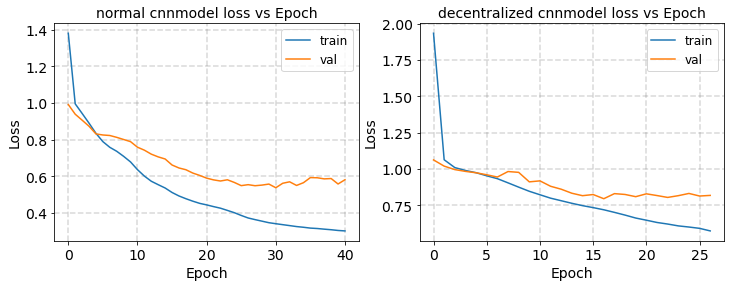

In [0]:
# plotting accuracy and loss 

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax = ax.flatten()

def loss_plot(hist_, ax, titl):
  ax.plot(hist_.history['loss'])
  ax.plot(hist_.history['val_loss'])
  ax.set_title(titl, fontsize = 14)
  ax.set_ylabel('Loss', fontsize = 14)
  ax.set_xlabel('Epoch', fontsize = 14)
  ax.tick_params(labelsize = 14)
  ax.legend(['train', 'val'], loc='best', fontsize = 12)
  ax.grid(True, lw = 1.5, ls = '--', color='gray', alpha = 0.3)

loss_plot(history, ax[0],'normal cnnmodel loss vs Epoch')
loss_plot(history_de, ax[1],'decentralized cnnmodel loss vs Epoch')


#### A function to plot predictions against true values

In [0]:
# Evaluation. modified from Ziwei's function

def my_rmse(lst1 = np.array([1,2,3,4,5]), lst2 = np.array([1,1,1,1,1])):
  summ = 0
  lst1 = list(lst1)
  lst2 = list(lst2)
  for i in range(len(lst1)):
    summ +=(lst1[i] - lst2[i])**2
  summ = round(summ/len(lst1),2)
  return summ
my_rmse()

def plot_prediction(cnnmodel, label_ind, ax,
                    num_of_pts = 200, 
                    image_te_name = "normal",
                    image_te = image_te,
                    cmap = "cividis",
                    fig = fig
                    ):
    ax.set_ylim()
    indices = np.random.randint(0, image_te.shape[0], num_of_pts)

    single_scaler = StandardScaler()

    single_scaler.fit(label_tr)

    label_pred_scaled = cnnmodel.predict(image_te[indices])
    label_pred = single_scaler.inverse_transform(label_pred_scaled)
    
    pred_vals = label_pred[:, label_ind]
    true_vals = label_te[indices,label_ind]

    max_val = max(np.max(pred_vals), np.max(true_vals))
    min_val = min(np.min(pred_vals), np.min(true_vals))

    pred_df = pd.DataFrame({ "True_value" : true_vals,
                              "Predicted_value": pred_vals})
    snr_spec = snr_te[indices]

    rmse_= my_rmse(pred_vals,true_vals)
      
    sns.lineplot("True_value", "True_value", color = 'red', sizes=(5), ax = ax, data = pred_df,
                 )

    sns.scatterplot("True_value", "Predicted_value", data = pred_df, 
               hue = snr_spec, palette = cmap,cmap=cmap,  ax = ax, s = 50, alpha =0.15,
               edgecolor="white", linewidth=0) #"seismic"
    titl_ = label_names_list[label_ind] + image_te_name + " rmse: " + str(rmse_)
    ax.set_xlabel('True Value', fontsize = 13)
    ax.set_ylabel('Predicted Value', fontsize = 13)
    ax.set_title(titl_ , fontsize = 13)
    #clb.set_label('S/N', labelpad=10, y=0.5, rotation=90, fontsize = 13)
    #plt.show()
    return ({"rmse": rmse_, "ylim" : [min_val, max_val]})
def plot_prediction_pretty(n, num_points = 500):
  fig, ax = plt.subplots(1,2, figsize=(12,6))
  ax = ax.flatten()
  sns.set_style("dark")
  ax[0].set_facecolor((0.15, 0.0, 0.15))
  ax[1].set_facecolor((0.15, 0.15, 0.0))

  dict_ = plot_prediction(cnnmodel, n, ax = ax[0], 
                  image_te  = image_te_decentered,num_of_pts = num_points, 
                  cmap = "cool")

  dict_de = plot_prediction(cnnmodel_de, n, ax = ax[1], 
                  image_te_name = " decentered model: " + str(), num_of_pts = num_points, 
                  image_te = image_te_decentered,
                  cmap = "cool")
  
  min1, max1 = dict_["ylim"]
  min_de, max_de = dict_de["ylim"]

  rmse_      = dict_["rmse"]
  rmse_de    = dict_de["rmse"]

  min_val = min(min1,min_de)
  max_val = min(max1,max_de)

  ax[0].set_ylim(min_val, max_val)
  ax[1].set_ylim(min_val, max_val)

In [0]:
image_te.shape

(3756, 64, 64, 1)

### Comparing Predictions to True values

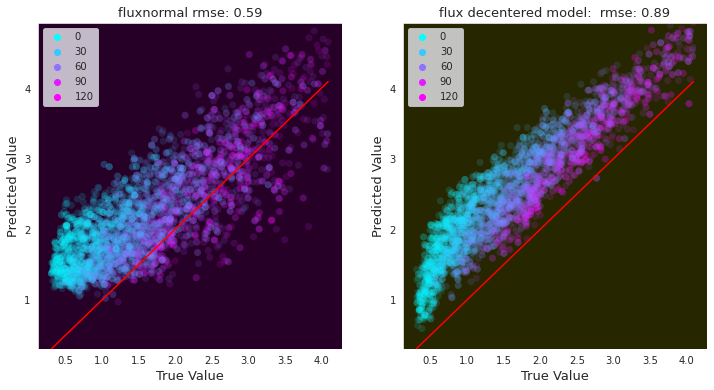

In [0]:

plot_prediction_pretty(0, 3756) 

In [0]:
# bias variance tradeoff? axes aren't aligned

What we appear to be witnessing is something akin to a bias variance tradeoff. The model that trained on the decentred dataset for the various parameters are on the right, and the models trained on the un-decentered dataset is on the left.

For flux, the decentered-data trained model performed worse than the normal model, but for all of the other parameters: the sersic index, sersic radius, g1 and g2 the RMSE was lower for the model that emulated the perterbations in galaxy centers.

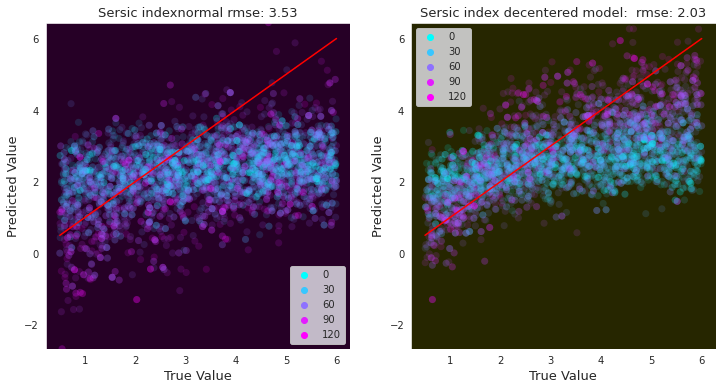

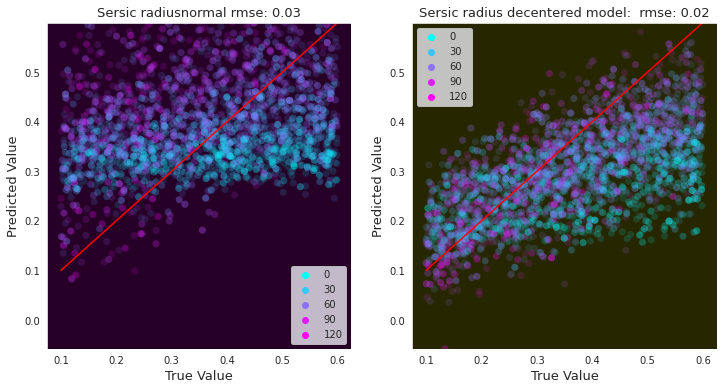

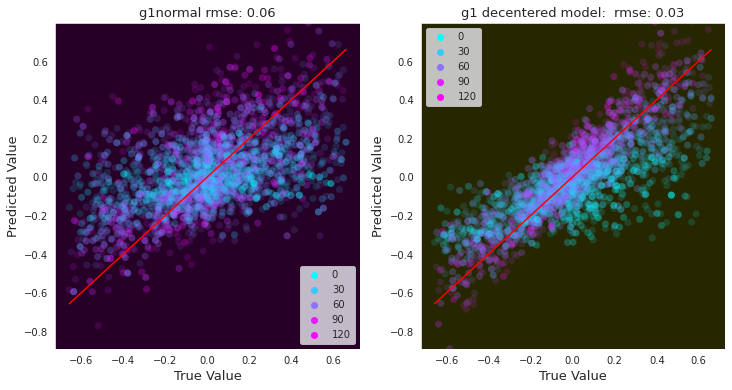

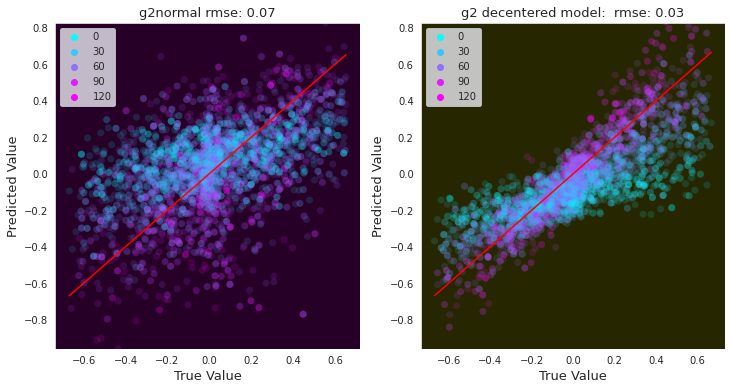

In [0]:
plot_prediction_pretty(1, 3756)
plot_prediction_pretty(2, 3756) 
plot_prediction_pretty(3, 3756)
plot_prediction_pretty(4, 3756)

![alt text](https://)

Basically, if we assume that the telescope will have error, then it is better to train on a dataset that hasn't been centered so that we can try to make the network robust to alignment errors. One could imagine how this could also apply to rotation errors and multiple objects.

# It's amazing that such a subtle change, basically invisible to the eye, can have such a profound impact on the performace of the model: basically cutting in half the error of the model in half on the test set.


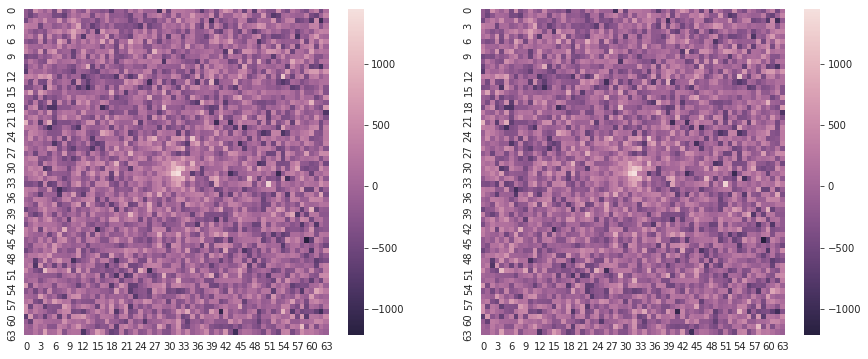

In [0]:
x
hi = randomly_decenter(image_tr[78,:,:,:].reshape(64,64), pixel_amt = 30, plott = True)

## Stretch Goal: Baseline Models

In [0]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit

In [0]:
f= h5py.File('Data1.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [0]:
print('image',image.shape)
print('cat',cat.shape)
print('label',label.shape)
print('snr',snr.shape)
print('sigma',sigma.shape)
print('image_nonoise',image_nonoise.shape)
print('image_withnoise',image_withnoise.shape)

image (18779, 64, 64)
cat (18779, 6, 64, 64)
label (18779, 5)
snr (18779,)
sigma (18779,)
image_nonoise (18779, 64, 64)
image_withnoise (18779, 64, 64)


In [0]:
get_elip1 = lambda g1,g2 : - (1+g1**2+g2**2-2*np.sqrt(g1**2+g2**2))/(-1+g1**2+g2**2)
get_theta = lambda g1,g2 : np.arctan2(-g1,-g2)

Some helper functions functions to convert g1 and g2 to elliptity and theta.

In [0]:
f=0.9 #use a 90% train test split. 
all_inds = np.linspace(0,len(label)-1,len(label)).astype(int)
train_inds = np.random.randint(0,len(label)-1,int(len(label)*f))
test_inds = np.setdiff1d(all_inds,train_inds)

In [0]:
train_nonoise = image_nonoise[train_inds]
test_nonoise = image_nonoise[test_inds]
train_noise = image_withnoise[train_inds]
test_noise = image_withnoise[test_inds]
train_label = label[train_inds]
test_label = label[test_inds]
train_snr = snr[train_inds]
test_snr = snr[test_inds]

In [0]:
train_flux = train_label[:,0]
test_flux = test_label[:,0]
train_index = train_label[:,1]
test_index = test_label[:,1]
train_rad = train_label[:,2]
test_rad = test_label[:,2]
train_g1 = train_label[:,3]
test_g1 = test_label[:,3]
train_g2 = train_label[:,4]
test_g2 = test_label[:,4]
train_ellip = get_elip1(train_g1,train_g2)
test_ellip = get_elip1(test_g1,test_g2)
train_theta = get_theta(train_g1,train_g2)
test_theta = get_theta(test_g1,test_g2)

In [0]:
len(train_index)
len(test_index)

7654

### Flux Model : Aperature Photometry

Text(0.5, 1.0, 'Centre')

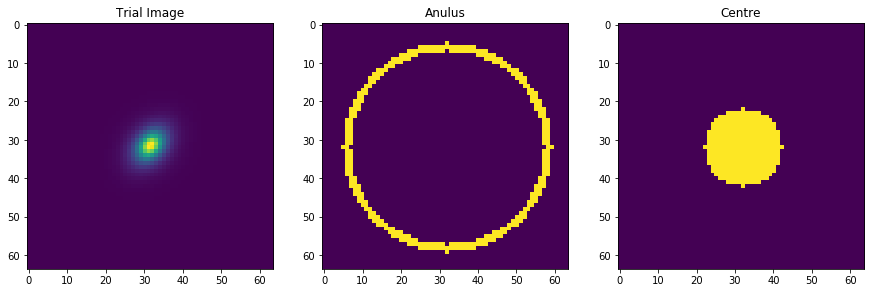

In [0]:
def getanulus(r2,r3):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask2 = x**2 + y**2 <= r2**2
    mask3 = x**2 + y**2 <= r3**2
    array = np.zeros((64, 64)) 
    array[mask3] = 1
    array[mask2] = 0
    return array

def getcentre(r1):
    y,x = np.ogrid[-32:64-32, -32:64-32]
    mask1 = x**2 + y**2 <= r1**2
    array = np.zeros((64, 64)) 
    array[mask1] = 1
    return array

#defining aperature sizes
r1,r2,r3= 10,25,27
anulus = getanulus(r2,r3)
centre = getcentre(r1)

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

ax[0].imshow(train_nonoise[0])
ax[0].set_title("Trial Image")
ax[1].imshow(anulus)
ax[1].set_title("Anulus")
ax[2].imshow(centre)
ax[2].set_title("Centre")

for the flux model we use aperature photometry. Here we take the center to be large enough to capture most of the light of the galaxy and the anulus to be an area far away from the galaxy. We sum up the flux through all the pixels in the anulus and divide by the number of images in the anulus to get the sky-brightness per pixel. We then subtract the flux in the center by this value * the number of pixels in the centre. We then assume the flux is given by some linear function of the resulting sum. (In reality we could determine this function by properly understanding our instrument and/or using a guide star. Nevertheless, we expect the intercept of this function to be relatively small since we got rid of the sky brightness). 

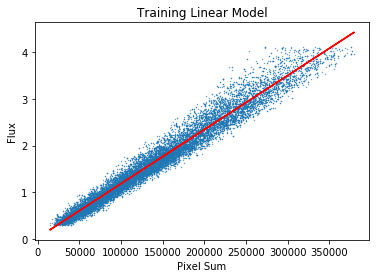

In [0]:
#train on noisy data, this is a highly vectorized aperature photometry scheme. Runs fast!
sky_per_pixel = np.sum((train_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((train_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel

model = np.polyfit(tots,train_flux,1)
plt.scatter(tots,train_flux,s=0.1)
plt.plot(tots,np.polyval(model,tots),c='r')
plt.title("Training Linear Model")
plt.xlabel("Pixel Sum")
plt.ylabel("Flux")

#make predictions
sky_per_pixel = np.sum((test_noise*anulus),(1,2))/(np.sum(anulus))
tots = np.sum((test_noise*centre),(1,2)) - np.sum(centre)*sky_per_pixel
pred_flux = np.polyval(model,tots)

The linear model looks good, small intercept! Next is a plot of the predictions on the test set.

(0, 4.5)

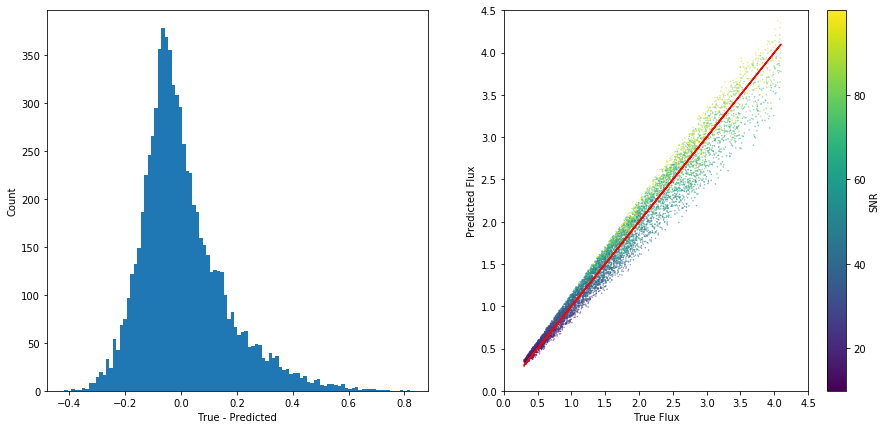

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
sc = ax[1].scatter(test_flux,pred_flux,s=0.1,c=test_snr)
flux_err = test_flux - pred_flux
plt.colorbar(sc,label='SNR')

ax[0].hist(flux_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

ax[1].plot(test_flux,test_flux,c='r')
ax[1].set_xlabel("True Flux")
ax[1].set_ylabel("Predicted Flux")
ax[1].set_xlim(0,4.5)
ax[1].set_ylim(0,4.5)

### Sersic Radius & Index Model

In [0]:
#some helper functions
b = lambda n: (2*n-1)/3
def func(r,Ie,n,Re):
    fac = (r/Re)**(1/n)
    return Ie*np.e**(-b(n)*(fac-1))

#example code
img = train_noise[0]
xgrid = np.linspace(0,63,64)
X,Y = np.meshgrid(xgrid,xgrid)
rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()

args = np.argsort(rs)
rs = rs[args]
vals = img.flatten()[args]
#normalize to avoid bad behavior
nvals = vals/np.max(vals)
#only choose r up to 20 pixels away so we avoid fitting too much noise, exclude where r=0. 
inds = np.where((rs<20)& (rs>0) & (nvals>0))
popt, pcov = curve_fit(func, rs[inds], nvals[inds],maxfev=10000)

fig,ax = plt.subplots(ncols=2,figsize=(15,7))
ax[0].imshow(img)
ax[0].set_title("Trial Image")
ax[1].scatter(rs[inds],nvals[inds],s=1,label='data')
ax[1].plot(rs,func(rs,*popt),c='r',label='fit profile')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_ylim(2.5e-3,1e1)
ax[1].set_xlim(1e0,5e1)
ax[1].set_title("Trial Fit")
ax[1].set_xlabel("Radial distance from image centre")
ax[1].set_title("Normalized Intensity")
ax[1].legend()
plt.show()

For the sersic model we simpliy fit a sersic profile to the galaxy assuming its at the centre of the image. We normalize the image before hand and write our profile in terms of the half light radius, the intensity and the index. We fit data only at positive non-zero r < 20.  This is to avoid fitting too much noise - which causes a slowdown in our fitting routine. (Note we expect this approach to be problematic especially with highly oblate galaxies - should we have intended this to be a more complicated model it would've been good to take into account ellipticity of the galaxies, but this is fine for a naieve baseline). We have bounded our fits informed by our EDA, again to help with speed. 

In [0]:
def get_sersic(img):
    xgrid = np.linspace(0,63,64)
    X,Y = np.meshgrid(xgrid,xgrid)
    rs = np.sqrt((X-32)**2 + (Y-32)**2).flatten()
    vals = img.flatten()
    nvals = vals/np.max(vals)
    #remember to remove the one point where r=0
    inds = np.where((rs<20)& (rs>0) & (nvals>0))
    bounds = [[0,0,0],[2,6,0.7]]
    popt, pcov = curve_fit(func, rs[inds], nvals[inds],bounds=bounds)
    return popt[1:]

#Since this is a direct fit, we don't need the train set in this case
out = []
for i in range(len(test_noise)):
    out.append(get_sersic(test_noise[i]))
out = np.asarray(out)
pred_index = out.T[0]
pred_rad = out.T[1]

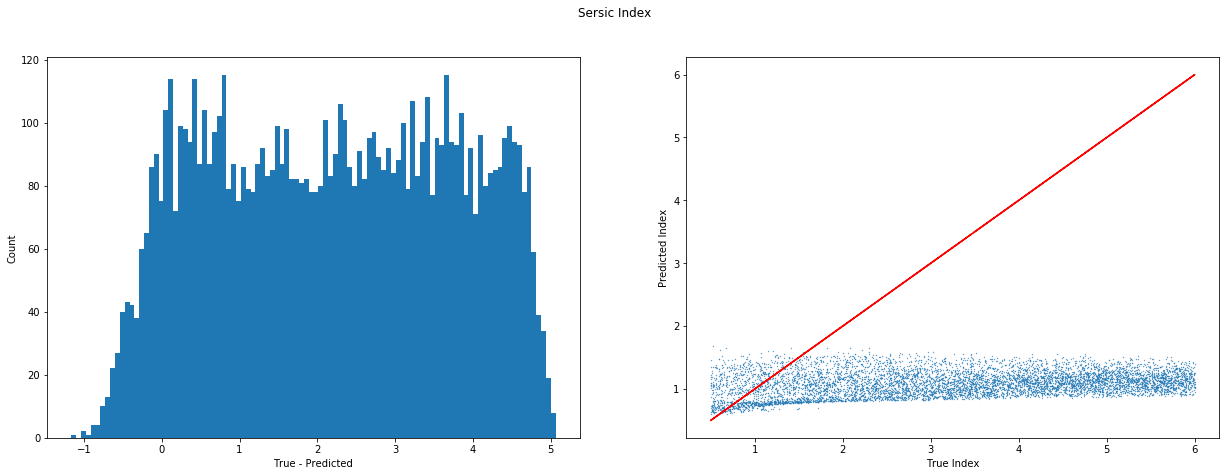

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
index_err = test_index-pred_index
ax[0].hist(index_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

ax[1].scatter(test_index,pred_index,s=0.1)
ax[1].set_ylabel("Predicted Index")
ax[1].set_xlabel("True Index")
ax[1].plot(test_index,test_index,c='r')
plt.suptitle("Sersic Index")
plt.show()

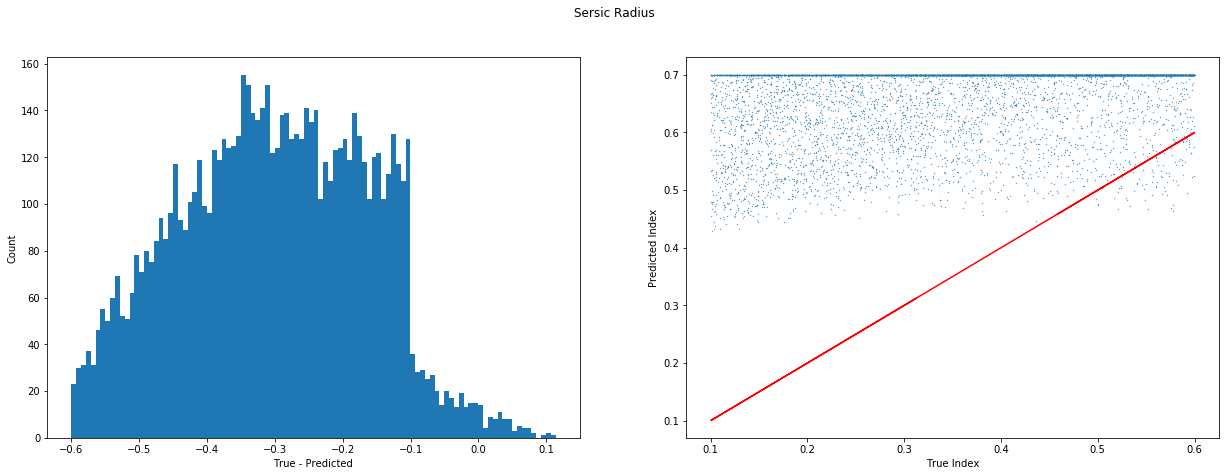

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
rad_err = test_rad-pred_rad
ax[0].hist(rad_err,bins=100)
ax[0].set_xlabel("True - Predicted")
ax[0].set_ylabel("Count")

rad_model = np.polyfit(test_rad,pred_rad,2)
ax[1].scatter(test_rad,pred_rad,s=0.1)
ax[1].set_ylabel("Predicted Index")
ax[1].set_xlabel("True Index")
ax[1].plot(test_rad,test_rad,c='r')
plt.suptitle("Sersic Radius")
plt.show()

As expected, this model has little predictive power, predicting essentially a constant for both the Sersic Radius and Index. In this case we simply use the results from directly fitting the train data. In principle we could make a linear model based on the train data, but if the prediction is constant - or nearly so, it won't improve the predictions. 

### g1 and g2 model

In [0]:
#modified from stackoverflow: 
#https://stackoverflow.com/questions/21566379/fitting-a-2d-gaussian-function-using-scipy-optimize-curve-fit-valueerror-and-m

def twoD_Gaussian2(coords, sigma_x, sigma_y, theta):
    #Setting a bunch of parameters, speeds up the fitting!
    xo=31.5
    yo=31.5
    offset=0.0
    amplitude=1.0
    (x, y) = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(nimg):
    img = nimg/np.max(nimg)

    x = np.linspace(0, 63, 64)
    y = np.linspace(0, 63, 64)
    x, y = np.meshgrid(x, y)
    #first three parameters are set, the others I guess at the middle of their intervals
    initial_guess = (3.5,3.5,np.pi/2)
    bounds = [[0,0,0],[7,7,np.pi]]
    popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
    data_fitted = twoD_Gaussian2((x, y), *popt)

    sigx = popt[0]
    sigy = popt[1]
    theta = popt[2]
    #minor over major axis
    guess_elip = np.min([sigx,sigy])/np.max([sigx,sigy])
    return theta,guess_elip

To estimate g1 and g2 our plan is to fit a gaussian to the image, derive the ellipticity and orientation to the fit and use these to derive g1 and g2. First lets look at rotations of our gaussian:

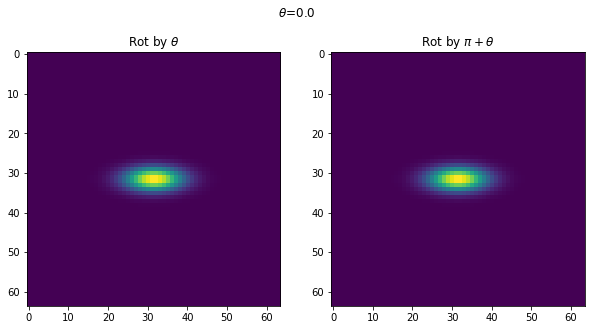

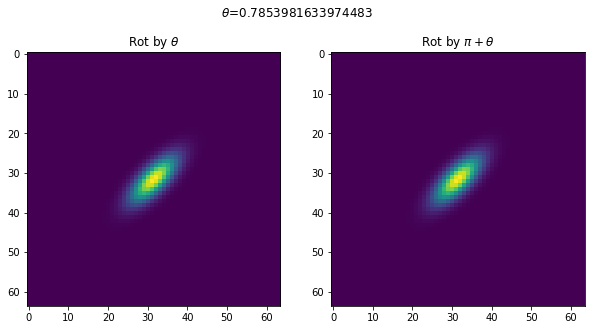

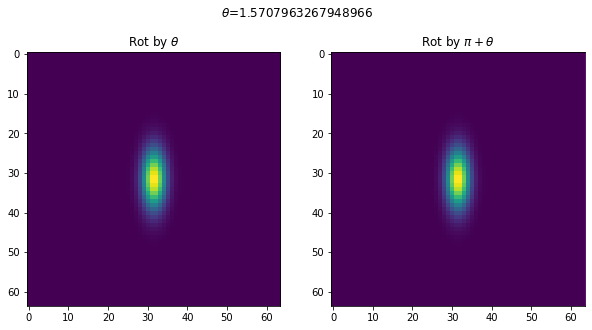

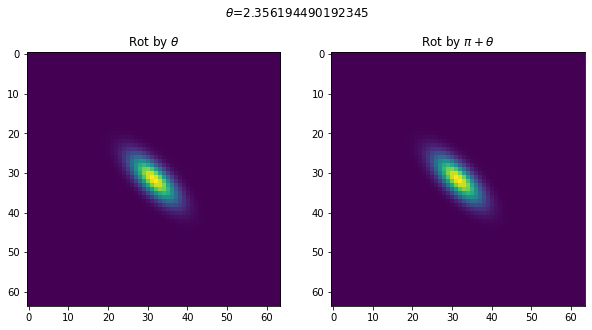

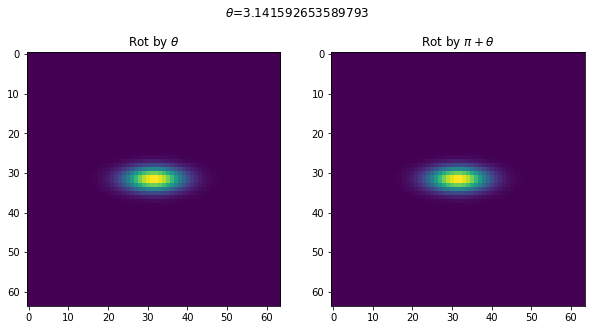

In [0]:
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)

thetas = np.linspace(0,np.pi,5)
for theta in thetas:
    fig,ax = plt.subplots(ncols=2,figsize=(10,5))
    data_fitted = twoD_Gaussian2((x, y), 5,2,theta)
    ax[0].imshow(data_fitted.reshape(64, 64))
    ax[0].set_title(r"Rot by $\theta$")
    data_fitted = twoD_Gaussian2((x, y), 5,2,np.pi+theta)
    ax[1].imshow(data_fitted.reshape(64, 64))
    ax[1].set_title(r"Rot by $\pi + \theta$")
    plt.suptitle(r'$\theta$='+str(theta))
    plt.show()

Note that since the gaussian is perfectly symmetric, rotations by $\pi$ look just like rotations by $2\pi$. This will come into play later.  For now we'll fit normalized images to reduce the parameter space we must explore. This will help with speed. 

[ 2.26698544  3.09380169 -0.70743745]


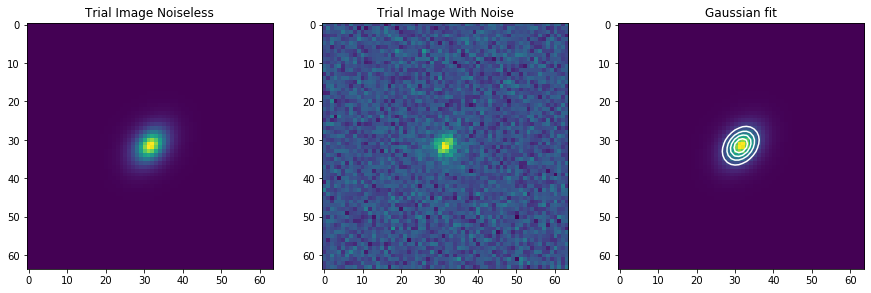

In [0]:
fig, ax = plt.subplots(ncols=3,figsize=(15,5))

img = train_nonoise[0]/np.max(train_nonoise[0])
x = np.linspace(0, 63, 64)
y = np.linspace(0, 63, 64)
x, y = np.meshgrid(x, y)
#first three parameters are set, the others I guess at 0
initial_guess = (3.5,3.5,np.pi/2)
bounds = [[0,0,-np.pi],[7,7,np.pi]]
popt, pcov = curve_fit(twoD_Gaussian2, (x, y), img.flatten(), p0=initial_guess,bounds=bounds)
data_fitted = twoD_Gaussian2((x, y), *popt)

ax[0].imshow(img)
ax[0].set_title("Trial Image Noiseless")
ax[1].imshow(train_noise[5])
ax[1].set_title("Trial Image With Noise")
ax[2].imshow(img)
ax[2].contour(x, y, data_fitted.reshape(64, 64), 4, colors='w')
ax[2].set_title("Gaussian fit")
print(popt)

In [0]:
#fit to train
out = []
for i in range(len(train_noise)):
    out.append(fit_gaussian(train_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
model = np.polyfit(pred_ellips,train_ellip,3)
pred2_ellips = np.polyval(model,pred_ellips)
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

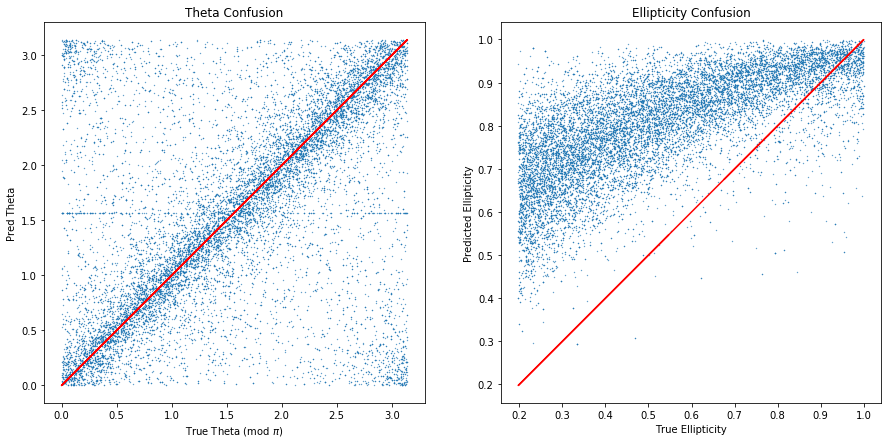

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(15,7))
ax[0].scatter(np.mod(train_theta,np.pi),pred2_thetas,s=0.1)
ax[0].plot(np.mod(train_theta,np.pi),np.mod(train_theta,np.pi),c='r')
ax[0].set_xlabel(r"True Theta (mod $\pi$)")
ax[0].set_ylabel(r"Pred Theta")
ax[0].set_title(r"Theta Confusion")

plt.scatter(train_ellip,pred_ellips,s=0.1)
plt.plot(train_ellip,train_ellip,c='r')
ax[1].set_xlabel(r"True Ellipticity")
ax[1].set_ylabel(r"Predicted Ellipticity")
ax[1].set_title(r"Ellipticity Confusion")
plt.show()

Here's the predicitions on the training data we do very well with the $\theta$ parameter (we have to mod this $2\pi$ since my symmetric gaussian model can't distinguish between positive and negative angles. We do well with the magnitude though!). For the ellipticity we don't do very well, but unlike the sersic parameters there's actually some information there. We'll incorporate a linear fit into our model, which should improve it slightly. 

In [0]:
#predict on test
out = []
for i in range(len(test_noise)):
    out.append(fit_gaussian(test_noise[i]))
out = np.asarray(out)
pred_thetas = out.T[0]
pred_ellips = out.T[1]
pred2_ellips = np.polyval(model,pred_ellips)
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)
pred_g1 = ((1-pred2_ellips)/(1+pred2_ellips))*np.sin(pred2_thetas)
pred_g2 = np.abs(((1-pred2_ellips)/(1+pred2_ellips))*np.cos(pred2_thetas))

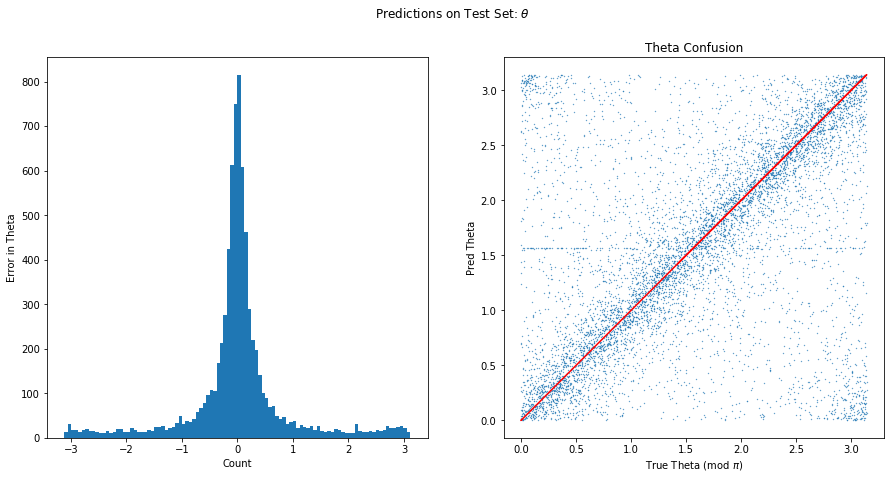

In [0]:
pred2_thetas = 2*np.mod(pred_thetas-np.pi/4,np.pi/2)

fig,ax = plt.subplots(ncols=2,figsize=(15,7))
theta_err = np.mod(test_theta,np.pi)-pred2_thetas
ax[0].hist(theta_err,bins=100)
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in Theta")
ax[1].scatter(np.mod(test_theta,np.pi),pred2_thetas,s=0.1)
ax[1].plot(np.mod(test_theta,np.pi),np.mod(test_theta,np.pi),c='r')
ax[1].set_xlabel(r"True Theta (mod $\pi$)")
ax[1].set_ylabel(r"Pred Theta")
ax[1].set_title(r"Theta Confusion")
plt.suptitle(r"Predictions on Test Set: $\theta$")
plt.show()

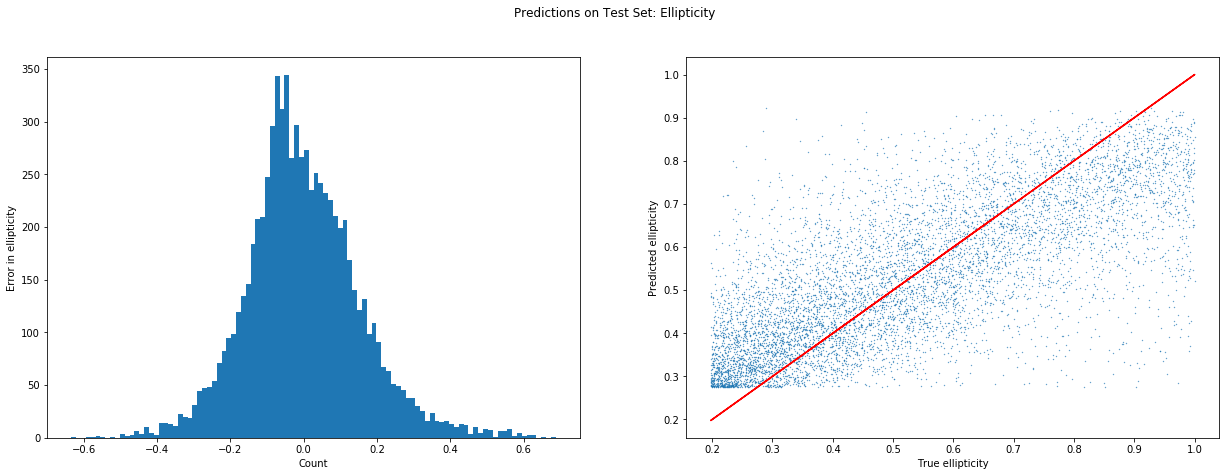

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
ellip_err = test_ellip-pred2_ellips
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in ellipticity")

ax[0].hist(ellip_err,bins=100)
ax[1].scatter(test_ellip,pred2_ellips,s=0.1)
ax[1].set_xlabel("True ellipticity")
ax[1].set_ylabel("Predicted ellipticity")
ax[1].plot(test_ellip,test_ellip,c='r')
plt.suptitle(r"Predictions on Test Set: Ellipticity")
plt.show()

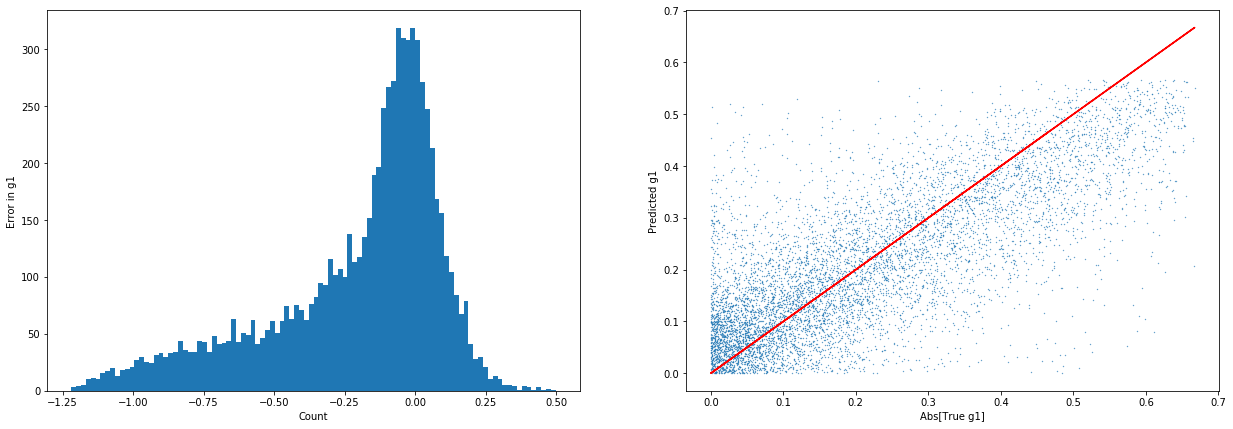

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
g1_err = test_g1-pred_g1
ax[0].hist(g1_err,bins=100)
ax[0].set_xlabel(r"Count")
ax[0].set_ylabel(r"Error in g1")

ax[1].scatter(np.abs(test_g1),pred_g1,s=0.1)
ax[1].set_ylabel("Predicted g1")
ax[1].set_xlabel("Abs[True g1]")

ax[1].plot(np.abs(test_g1),np.abs(test_g1),c='r')

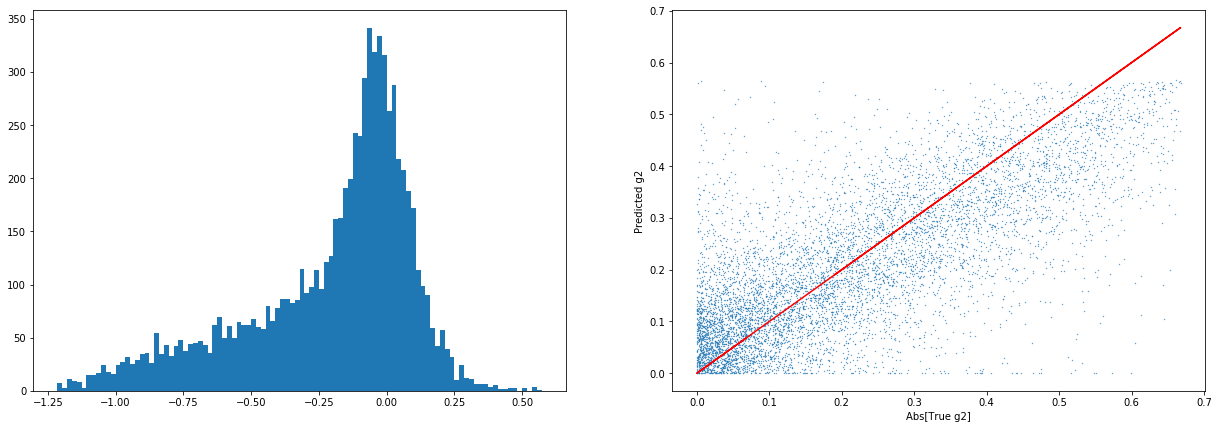

In [0]:
fig,ax = plt.subplots(ncols=2,figsize=(21,7))
g2_err = test_g2-pred_g2
ax[0].hist(g2_err,bins=100)

ax[1].scatter(np.abs(test_g2),pred_g2,s=0.1)
ax[1].set_ylabel("Predicted g2")
ax[1].set_xlabel("Abs[True g2]")

ax[1].plot(np.abs(test_g2),np.abs(test_g2),c='r')

Now we can look at the predictions on the test set. In general I do fairly well, but theres a long spread. There's also the caveat that I can only do predictions on the magnitude of the g1 and g2 values. 

In [0]:
pred_label = np.asarray([pred_flux,pred_index,pred_rad,pred_g1,pred_g2]).T
np.save('test_params.npy',test_label.astype(float))
np.save('pred_params.npy',pred_label.astype(float))
np.save('snr.npy',test_snr.astype(float))

Just outputing arrays to file

### Summary: baseline models

To be thorough, lets make a confusion matrix of all our predctions and their depdencies!

In [0]:
errors = np.asarray([flux_err,index_err,rad_err,g1_err,g2_err,theta_err,ellip_err])
true_vals = np.asarray([test_flux,test_index,test_rad,test_g1,test_g2,test_theta,test_ellip,test_snr])
errorlabels = ['Flux Error','Index Error','Radius Error','g1 Error','g2 Error','Theta Error','Ellipticity Error']
truthlabels = ['True Flux','True Index','True Radius','np.abs(True g1)','np.abs(True g2)','True Theta','True Ellipticity','True SNR']

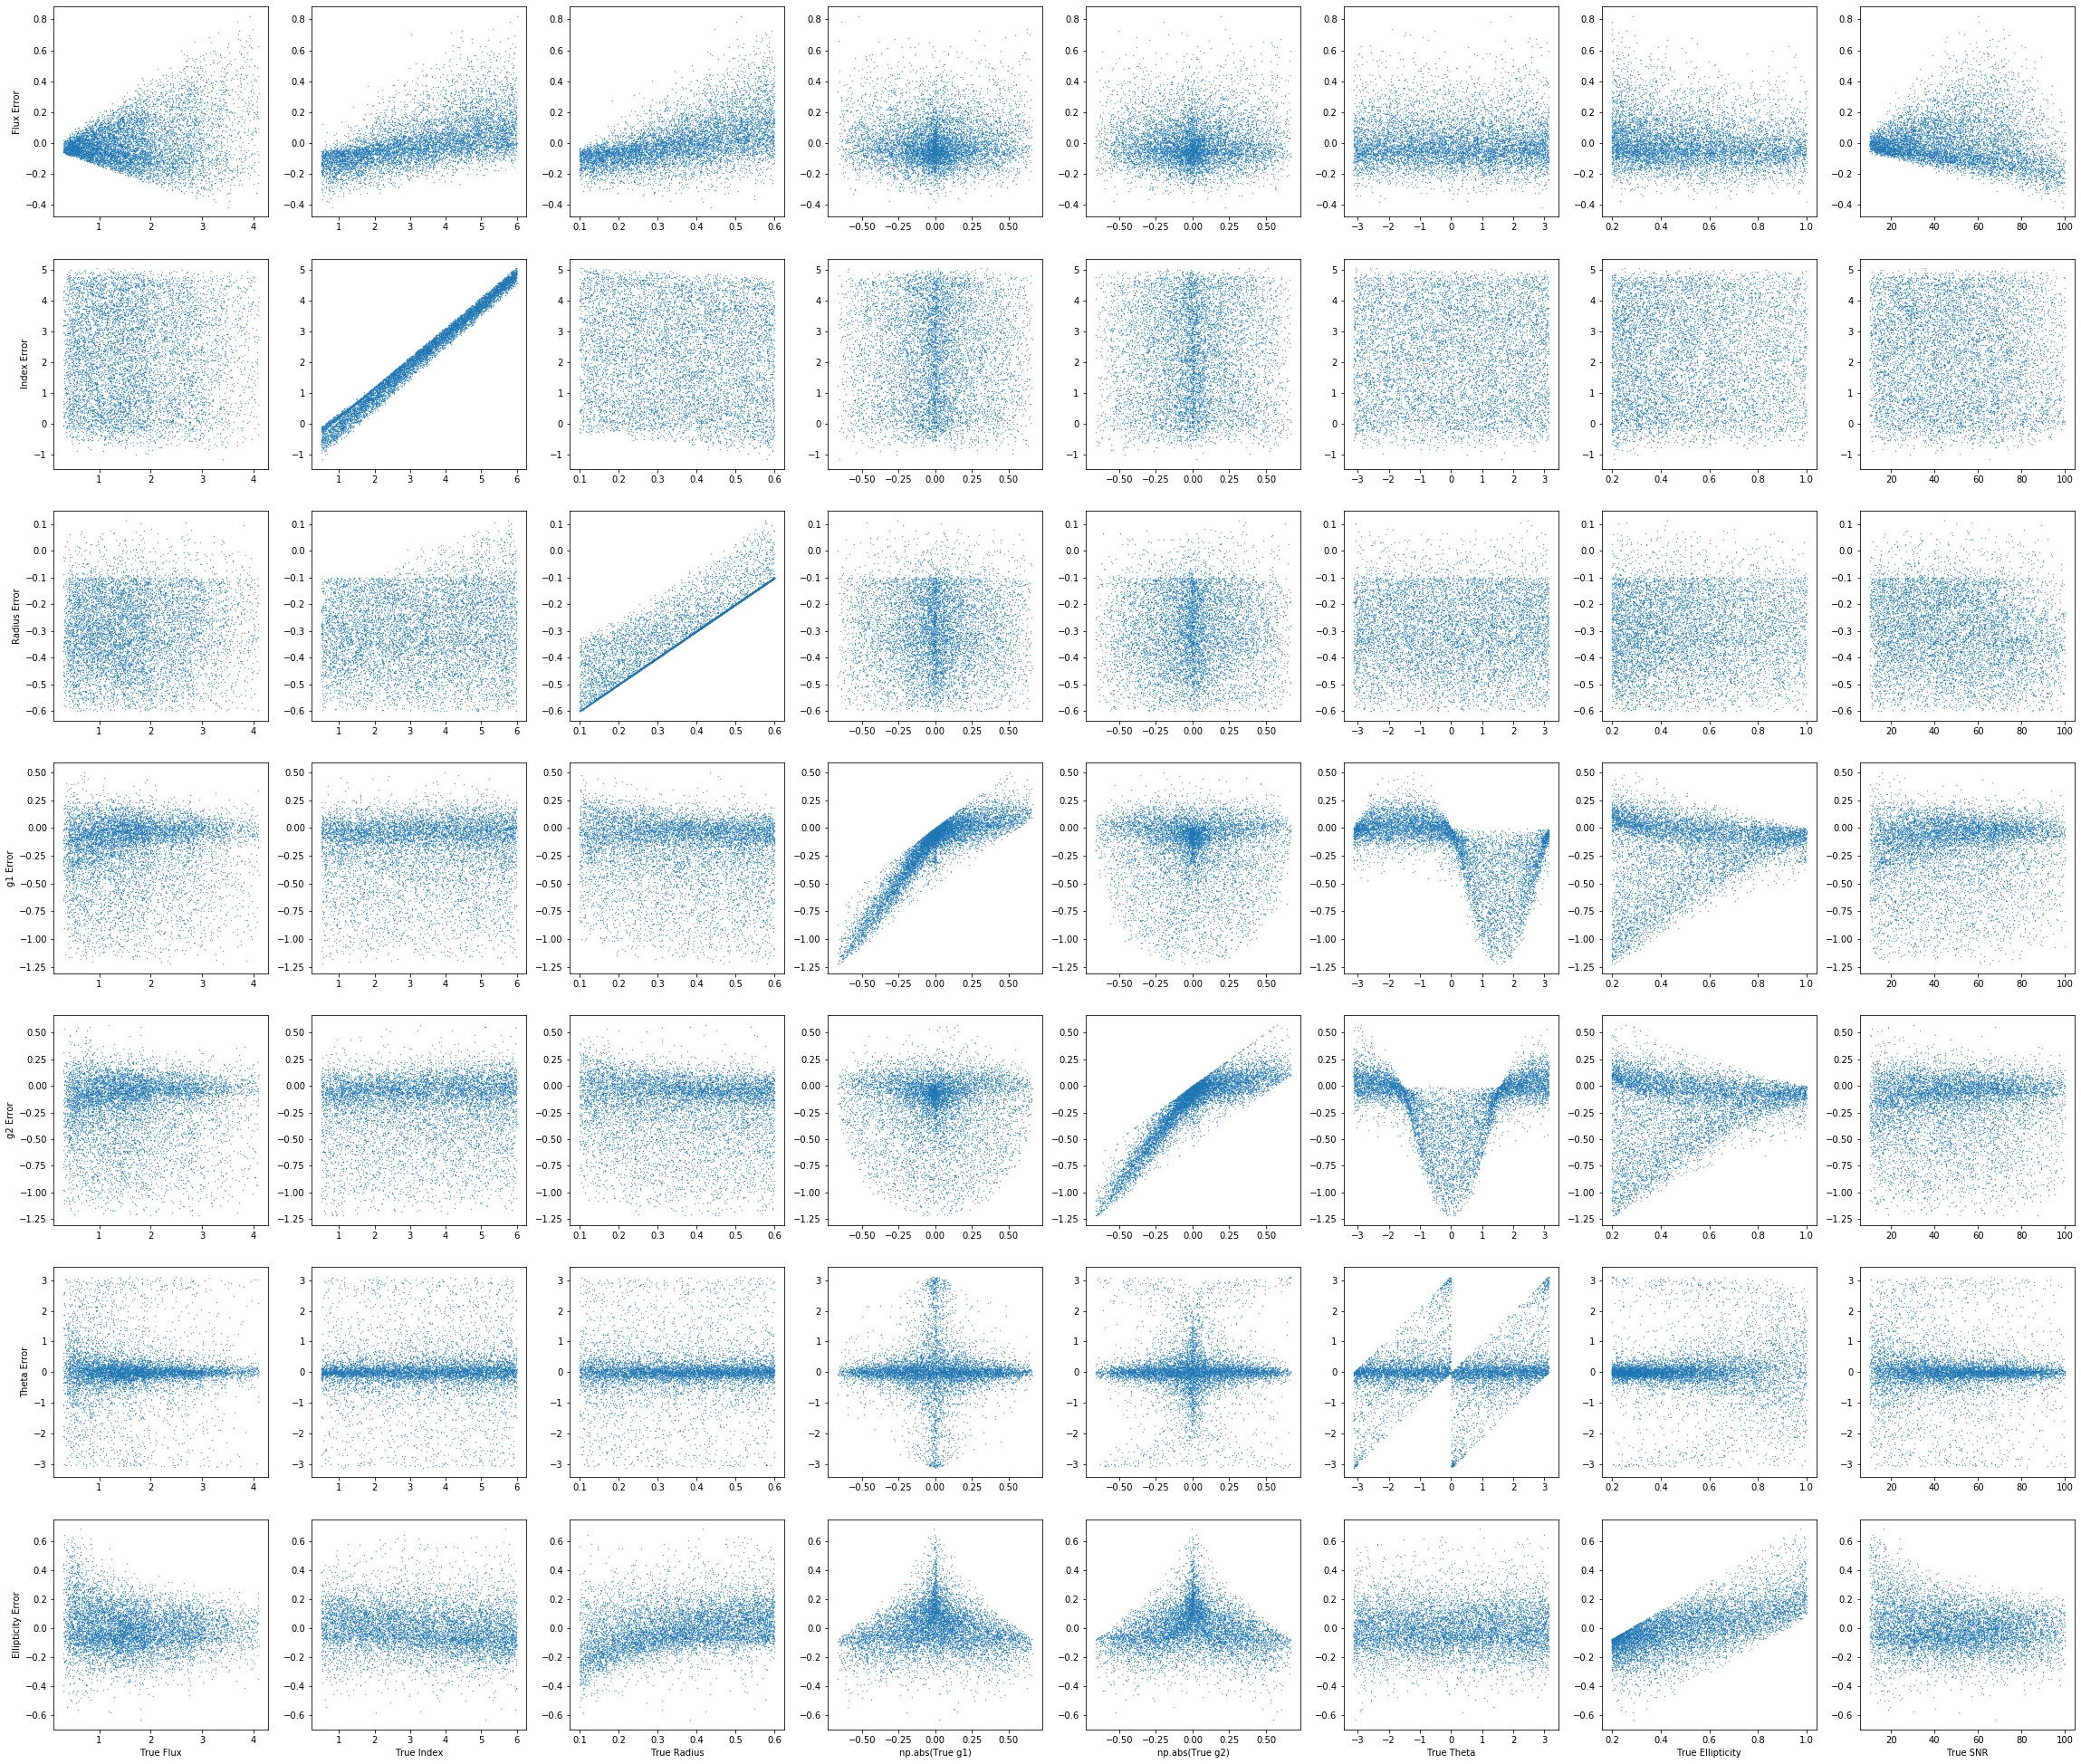

In [0]:
fig,ax = plt.subplots(ncols=len(true_vals),nrows=len(errors),figsize=(40,35))
for i in range(len(true_vals)):
    for j in range(len(errors)):
        ax[j,i].scatter(true_vals[i],errors[j],s=0.1)
        
for i in range(len(true_vals)):
    ax[-1,i].set_xlabel(truthlabels[i])
    
for j in range(len(errorlabels)):
    ax[j,0].set_ylabel(errorlabels[j])

There's a lot of interesting things we can note here:

1. The absolute error in flux becomes larger as the flux increases and we are biased to lower flux levels at extremely high signal to noise. Large sersic radii and indexes bias in the opposite direction. This is rather surprising (one might expect brighter sources to be easier to characterize), but it's important to keep in mind we're fitting absolute error - it's likely the fractional error in the flux decreases with increasing flux. 

2. The error in the sersic index is larger for larger sersic indexes (perhaps a larger sersic index is a more gradual change and is harder to pick up on?). Dosen't seem to depend much on anythin else

3. The error in sersic radius depends on the sersic radius, but more loosely than the index. It always seems underestimated. 

4. The erorr in g1 and g2 both care very much on g1 and g2, extreme values (especially negative ones) cause underestimates. This is dominated by errors in fitting extremely elliptical galaxies. Theres's also an interesting correlation with theta, but that's likely geometric. 

5. The error in theta seems independ of all other parameters (except g1,g2 and theta which are geomemtrically connected). 

6. The error in fitting elipticity is much larger at low fluxes and low signal to noise levels (which makes sense!). There are also geometric correlations with g1 and g2 - as expected.

## Conclusions

* CNNs can be used for modeling galaxy parameters with some success, although they have difficulty with estimating Sersic index and to a lesser extent Sersic radius.


* The models' prediction-uncertainties are often close to the the Cramer-Rao bound. 


* CNN models with a descending number of filters result in better performance than those with an ascending number of filters. 


* Differences in the training and testing point-spread function can severely degrade model performance: however, this effect is reduced if the model is trained on images with varying PSF.


* Training on augmented data (decentered data) greatly improves performance.


* CNNs do significantly better than baseline models on 4 out of 5 of the Sersic parameters and perform comparably on the 5th. 

